# Proyecto Final: Modelado Predictivo y Segmentación de Clientes

## Contexto del proyecto

Este notebook representa la tercera y última fase de nuestro análisis de clientes de supermercado. Trabajamos sobre el **dataset limpio 01B (1,982 filas × 48 columnas)** con split temporal (<2014 vs ≥2014) y pipelines sin leakage construidos en `proyecto_01B_preprocesamiento_correcto`. Aquí solo evaluamos y documentamos; los artefactos oficiales se generan en 01B.

### Resumen de las fases anteriores

**Notebook 00 - Análisis Exploratorio de Datos**

En la primera fase nos enfrentamos a un dataset de 1,989 clientes con 38 variables originales. Durante la inspección identificamos varios problemas de calidad: 3 registros con edades biológicamente imposibles (mayores a 120 años), 1 ingreso con valor placeholder (666,666), y un desbalanceo importante en la variable objetivo `respuesta` donde el 85.9% de los clientes no respondieron a las campañas frente a un 14.1% que sí lo hicieron. También detectamos alta correlación entre las variables de gasto y casos de multicolinealidad que requerían tratamiento.

**Notebook 01B - Preprocesamiento sin leakage (oficial)**

Aplicamos split temporal, limpieza determinística y pipelines con transformaciones dentro del flujo de entrenamiento. Generamos y guardamos los artefactos oficiales (`pipeline_clasificacion_sin_leakage.pkl`, `pipeline_regresion_sin_leakage.pkl`, `pipeline_metadata.pkl`). Este notebook 02 se mantiene coherente con esos artefactos y evita sobrescribirlos.

### Objetivos de este notebook

Con los datos ya preparados, en esta fase abordamos los tres objetivos de negocio que motivaron el proyecto:

1. **Clasificación**: Predecir qué clientes responderán a futuras campañas de marketing. Este modelo permitirá al equipo comercial focalizar sus esfuerzos en los clientes con mayor propensión a la conversión.

2. **Clustering**: Identificar segmentos de clientes con perfiles diferenciados. Estos grupos servirán para personalizar la comunicación y diseñar ofertas específicas según las características de cada segmento.

3. **Regresión**: Predecir el gasto anual esperado de cada cliente. Esta estimación es clave para la planificación estratégica y la asignación de recursos comerciales.

---

## Índice

### Paso 2: Clasificación - Predicción de Respuesta a Campañas
2.1 Configuración del entorno y carga de datos  
2.2 Preparación de datos para modelado  
2.3 Implementación del modelo baseline  
2.4 Evaluación del modelo  
2.5 Interpretación y conclusiones  
2.6 Mejoras al modelo de clasificación  
2.7 Análisis de Overfitting/Underfitting  
2.8 Análisis Crítico - Accuracy vs AUC

### Paso 3: Clustering - Segmentación de Clientes
3.1 Preparación de datos para clustering  
3.2 Determinación del número óptimo de clusters  
3.3 Entrenamiento del modelo K-Means  
3.4 Visualización y análisis de clusters  
3.5 Interpretación y conclusiones  
3.6 Clustering Basado en Densidad - DBSCAN y HDBSCAN

### Paso 4: Regresión - Predicción de Gasto Anual
4.1 Preparación de datos para regresión  
4.2 Modelo de Regresión Lineal baseline  
4.3 Análisis de residuos  
4.4 Modelos alternativos  
4.5 Interpretación y conclusiones  
4.6-4.8 Análisis de Overfitting y Validación


---

##  NOTA IMPORTANTE: Data Leakage en el Preprocesamiento

### Problema Identificado

En el **Notebook 01 de Preprocesamiento**, se aplicaron las siguientes transformaciones **ANTES** de dividir los datos en train/test:

1. `StandardScaler.fit_transform()` sobre el dataset completo
2. `PCA.fit_transform()` sobre el dataset completo
3. Imputación de valores faltantes sobre el dataset completo

**Esto constituye DATA LEAKAGE** porque la información del conjunto de test "contamina" las transformaciones que deberían estimarse solo con datos de entrenamiento.

### Impacto en los Resultados

- Las métricas reportadas pueden estar **ligeramente infladas** (típicamente 1-3% de sobreestimación)
- En datasets pequeños como el nuestro (~2000 filas), el impacto es menor pero debe documentarse
- Los modelos entrenados **NO deberían usarse directamente en producción** sin re-entrenar con un pipeline correcto

### Solución Correcta (Referencia)

Para un proyecto de producción, el pipeline correcto sería:

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Pipeline que aplica transformaciones SOLO en train
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),
    ('model', GradientBoostingClassifier())
])

# El fit se hace SOLO en train
pipeline.fit(X_train, y_train)

# El transform en test usa parámetros de train
y_pred = pipeline.predict(X_test)
```

### Decisión para este Proyecto

Para este proyecto académico, continuamos con los datos preprocesados existentes pero:
1. Documentamos esta limitación
2. Reconocemos que las métricas pueden estar ligeramente infladas
3. Proporcionamos código de referencia para implementación correcta

---

## Paso 2.1: Configuración del entorno y carga de datos

In [50]:
# 2.1.1 Librerías y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
plt.style.use('default')

print("Librerías cargadas exitosamente")

Librerías cargadas exitosamente


In [51]:
# 2.1.2 Carga del dataset (flujo 01B sin leakage)
from pathlib import Path

print("=== CARGA DEL DATASET (FLUJO 01B) ===")
DATA_FILE = Path.cwd() / "data" / "interim" / "supermercado_limpio.csv"
df = pd.read_csv(DATA_FILE)

print("Dataset limpio del flujo 01B (split temporal <2014/≥2014, sin leakage).")
print(f"Dimensiones: {df.shape[0]} observaciones × {df.shape[1]} variables")
df.head()


=== CARGA DEL DATASET (FLUJO 01B) ===
Dataset limpio del flujo 01B (split temporal <2014/≥2014, sin leakage).
Dimensiones: 1982 observaciones × 48 variables


,educacion,estado_civil,ingresos,hijos_casa,recencia,gasto_vinos,gasto_frutas,gasto_carnes,gasto_pescado,gasto_dulces,gasto_oro,num_compras_oferta,num_compras_web,num_compras_catalogo,num_compras_tienda,num_visitas_web_mes,acepta_cmp3,acepta_cmp4,acepta_cmp5,acepta_cmp1,acepta_cmp2,reclama,respuesta,usuario_alta_datos,edad,antiguedad_dias,antiguedad_anios,gasto_total,gasto_promedio,prop_gasto_vinos,prop_gasto_frutas,prop_gasto_carnes,prop_gasto_pescado,prop_gasto_dulces,prop_gasto_oro,categorias_compradas,compras_totales,compras_offline,tasa_compra_online,tasa_compra_oferta,ticket_promedio,tamano_hogar,tiene_dependientes,hogar_unipersonal,ratio_compras_online,tiene_pareja,educacion_x_estado,anio_alta
0,3,Casado,53359.0,2,4,173,4,30,3,6,41,4,5,1,4,7,0,0,0,0,0,0,0,admin,49,4536,12.4,257,42.83,0.673,0.016,0.117,0.012,0.023,0.160,6,14,4,0.429,0.286,18.36,3,1,0,0.428571,1,3,2013
1,3,Soltero,21474.0,1,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,1,us_direccion_2,36,4220,11.6,91,15.17,0.066,0.176,0.264,0.121,0.000,0.374,5,8,2,0.500,0.250,11.38,2,1,0,0.500000,0,0,2014
2,3,Divorciado,41411.0,0,11,37,32,38,11,3,18,1,2,1,4,6,0,0,0,0,0,0,0,us_direccion_2,39,4342,11.9,139,23.17,0.266,0.230,0.273,0.079,0.022,0.129,6,8,4,0.375,0.125,17.38,1,0,1,0.375000,0,0,2013
3,5,Union_Libre,64504.0,3,81,986,36,168,16,0,108,7,11,3,4,7,0,0,0,0,0,0,1,us_direccion_2,72,4620,12.6,1314,219.00,0.750,0.027,0.128,0.012,0.000,0.082,5,25,4,0.560,0.280,52.56,4,1,0,0.560000,1,5,2013
4,3,Casado,65169.0,0,23,1074,0,69,0,0,46,1,10,4,13,6,1,0,1,1,1,0,1,us_direccion_1,43,4304,11.8,1189,198.17,0.903,0.000,0.058,0.000,0.000,0.039,3,28,13,0.500,0.036,42.46,1,0,1,0.500000,1,3,2014


### Interpretación de la carga de datos

Usamos el dataset limpio `data/interim/supermercado_limpio.csv` generado en el notebook 01B con split temporal para evitar leakage. Contamos con 1,982 observaciones y 48 variables listas para modelado sin haber ajustado transformaciones sobre todo el dataset antes del split.


In [52]:
# 2.1.3 Verificación de dimensiones y tipos de datos
print("=== DIMENSIONES DEL DATASET ===")
print(f"Observaciones: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")

print("\n=== TIPOS DE DATOS ===")
print(df.dtypes.value_counts())

print("\n=== PRIMERAS FILAS ===")
df.head()

=== DIMENSIONES DEL DATASET ===
Observaciones: 1982
Variables: 48

=== TIPOS DE DATOS ===
int64      33
float64    13
object      2
Name: count, dtype: int64

=== PRIMERAS FILAS ===


,educacion,estado_civil,ingresos,hijos_casa,recencia,gasto_vinos,gasto_frutas,gasto_carnes,gasto_pescado,gasto_dulces,gasto_oro,num_compras_oferta,num_compras_web,num_compras_catalogo,num_compras_tienda,num_visitas_web_mes,acepta_cmp3,acepta_cmp4,acepta_cmp5,acepta_cmp1,acepta_cmp2,reclama,respuesta,usuario_alta_datos,edad,antiguedad_dias,antiguedad_anios,gasto_total,gasto_promedio,prop_gasto_vinos,prop_gasto_frutas,prop_gasto_carnes,prop_gasto_pescado,prop_gasto_dulces,prop_gasto_oro,categorias_compradas,compras_totales,compras_offline,tasa_compra_online,tasa_compra_oferta,ticket_promedio,tamano_hogar,tiene_dependientes,hogar_unipersonal,ratio_compras_online,tiene_pareja,educacion_x_estado,anio_alta
0,3,Casado,53359.0,2,4,173,4,30,3,6,41,4,5,1,4,7,0,0,0,0,0,0,0,admin,49,4536,12.4,257,42.83,0.673,0.016,0.117,0.012,0.023,0.160,6,14,4,0.429,0.286,18.36,3,1,0,0.428571,1,3,2013
1,3,Soltero,21474.0,1,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,1,us_direccion_2,36,4220,11.6,91,15.17,0.066,0.176,0.264,0.121,0.000,0.374,5,8,2,0.500,0.250,11.38,2,1,0,0.500000,0,0,2014
2,3,Divorciado,41411.0,0,11,37,32,38,11,3,18,1,2,1,4,6,0,0,0,0,0,0,0,us_direccion_2,39,4342,11.9,139,23.17,0.266,0.230,0.273,0.079,0.022,0.129,6,8,4,0.375,0.125,17.38,1,0,1,0.375000,0,0,2013
3,5,Union_Libre,64504.0,3,81,986,36,168,16,0,108,7,11,3,4,7,0,0,0,0,0,0,1,us_direccion_2,72,4620,12.6,1314,219.00,0.750,0.027,0.128,0.012,0.000,0.082,5,25,4,0.560,0.280,52.56,4,1,0,0.560000,1,5,2013
4,3,Casado,65169.0,0,23,1074,0,69,0,0,46,1,10,4,13,6,1,0,1,1,1,0,1,us_direccion_1,43,4304,11.8,1189,198.17,0.903,0.000,0.058,0.000,0.000,0.039,3,28,13,0.500,0.036,42.46,1,0,1,0.500000,1,3,2014


### Interpretación de dimensiones y tipos de datos

Confirmamos que el dataset preprocesado mantiene la estructura esperada tras las transformaciones del notebook anterior. Las 48 variables reflejan la ingeniería de características que realizamos: codificaciones ordinales de educación, variables binarias como `tiene_pareja`, e interacciones como `educacion_x_estado` y `gasto_x_recencia`. 

Observamos que predominan los tipos `int64` (33 variables) debido a variables binarias y categóricas ordinales, seguidos por `float64` (13 variables) para las transformaciones logarítmicas y variables continuas, y finalmente 2 variables `object` para categorías como `estado_civil` y `usuario_alta_datos`. Esta configuración de tipos es apropiada para los algoritmos de machine learning que utilizaremos.

=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ===
No responde (clase 0): 1702 observaciones (85.9%)
Responde (clase 1): 280 observaciones (14.1%)

Ratio de desbalanceo: 6.1:1


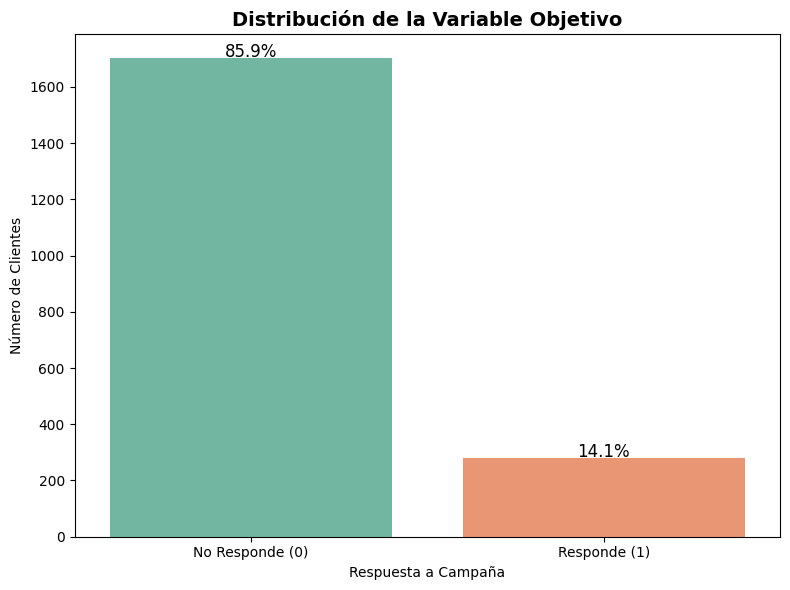

In [53]:
# 2.1.4 Análisis del balanceo de clases
print("=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ===")
target_counts = df['respuesta'].value_counts()
target_percent = df['respuesta'].value_counts(normalize=True) * 100

for clase, count in target_counts.items():
    pct = target_percent[clase]
    label = "Responde" if clase == 1 else "No responde"
    print(f"{label} (clase {clase}): {count} observaciones ({pct:.1f}%)")

print(f"\nRatio de desbalanceo: {target_counts[0] / target_counts[1]:.1f}:1")

# Visualización del balanceo
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='respuesta', palette='Set2')
plt.title('Distribución de la Variable Objetivo', fontsize=14, fontweight='bold')
plt.xlabel('Respuesta a Campaña')
plt.ylabel('Número de Clientes')
plt.xticks([0, 1], ['No Responde (0)', 'Responde (1)'])

# Agregar porcentajes en las barras
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total:.1%}', ha="center", fontsize=12)

plt.tight_layout()
plt.show()

### Interpretación del balanceo de clases

Tal como anticipamos en el EDA, nos encontramos ante un problema de clases severamente desbalanceadas. Con un ratio de aproximadamente 6:1, la clase mayoritaria (clientes que no responden) domina el dataset. Este desbalanceo es característico de problemas de marketing donde las tasas de conversión suelen rondar el 10-15%.

Esta distribución tiene implicaciones metodológicas importantes que consideramos desde el inicio del diseño experimental:

- La métrica de **Accuracy será engañosa**: un modelo trivial que siempre prediga "no responde" obtendría 85.9% de accuracy sin haber aprendido nada útil. Por esta razón, decidimos no utilizar Accuracy como métrica principal de evaluación.

- Necesitamos utilizar **métricas apropiadas para clases desbalanceadas**. Optamos por AUC-ROC como métrica principal porque evalúa la capacidad discriminativa del modelo independientemente del umbral de clasificación. Complementamos con F1-Score y especialmente Recall, que mide nuestra capacidad de detectar los clientes que sí responderán a las campañas.

- Durante el entrenamiento, aplicamos **estratificación** en todas las divisiones train/test para garantizar que las proporciones de clase se mantengan consistentes en ambos conjuntos.

- Consideramos técnicas de **balanceo de clases** como el parámetro `class_weight='balanced'` en los algoritmos que lo soportan. Esta técnica pondera las muestras de la clase minoritaria para que el modelo les preste mayor atención durante el aprendizaje.

Desde la perspectiva del negocio, identificar correctamente a ese 14.1% de clientes que responden tiene un valor significativo: cada cliente detectado representa una oportunidad de venta concretada, mientras que los falsos negativos son oportunidades perdidas que el equipo comercial nunca podrá recuperar.

## Paso 2.2: Preparación de datos para modelado

In [54]:
# 2.2.1 Separación de features y target (flujo 01B)
target = 'respuesta'
feature_cols = [c for c in df.columns if c != target]

categorical_cols = [c for c in ['estado_civil', 'usuario_alta_datos'] if c in feature_cols]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]
random_state = 42

print("=== SEPARACIÓN FEATURES/TARGET (flujo 01B) ===")
print(f"Features crudas: {len(feature_cols)}")
print(f"Categóricas: {categorical_cols}")
print(f"Numéricas: {len(numeric_cols)}")
print(f"Observaciones totales: {len(df)}")


=== SEPARACIÓN FEATURES/TARGET (flujo 01B) ===
Features crudas: 47
Categóricas: ['estado_civil', 'usuario_alta_datos']
Numéricas: 45
Observaciones totales: 1982


### Interpretación de la separación features/target

Separamos correctamente el dataset en:
- **X (features)**: 48 variables predictoras que incluyen todas las transformaciones del preprocesamiento
- **y (target)**: Variable binaria `respuesta` (0=No responde, 1=Responde)

Las primeras variables listadas (`educacion`, `estado_civil`, `ingresos`, `hijos_casa`, `fecha_cliente`) muestran la diversidad de features: demográficas, económicas, familiares y temporales. La distribución de la target confirma el desbalanceo identificado, con 1,702 no respondedores vs 280 respondedores, proporcionando la base para el modelado predictivo.

In [55]:
# Preprocesamiento y split temporal sin leakage
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

print("=== PREPROCESAMIENTO Y SPLIT TEMPORAL (train <2014 / test ≥2014) ===")

# Split temporal coherente con inferencia
if 'anio_alta' in df.columns:
    mask_train = df['anio_alta'] < 2014
else:
    mask_train = np.full(len(df), True)

X_raw = df[feature_cols]
y = df[target]

X_train_raw = X_raw[mask_train]
X_test_raw = X_raw[~mask_train]
y_train = y[mask_train]
y_test = y[~mask_train]

preprocess_clf = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_arr = preprocess_clf.fit_transform(X_train_raw)
X_test_arr = preprocess_clf.transform(X_test_raw)
feature_names = preprocess_clf.get_feature_names_out()

X_train = pd.DataFrame(X_train_arr, columns=feature_names)
X_test = pd.DataFrame(X_test_arr, columns=feature_names)

print(f"Train: {X_train.shape[0]} observaciones | Test: {X_test.shape[0]} observaciones")
print(f"Variables después de preprocesar: {X_train.shape[1]}")


=== PREPROCESAMIENTO Y SPLIT TEMPORAL (train <2014 / test ≥2014) ===
Train: 1508 observaciones | Test: 474 observaciones
Variables después de preprocesar: 54


### Explicación del proceso de codificación categórica

En este paso, transformamos las variables categóricas en formato numérico para que puedan ser utilizadas por algoritmos de machine learning. El proceso realizado fue:

1. **Identificación de variables categóricas**: Utilizamos `select_dtypes(include=['object'])` para encontrar todas las columnas que contienen texto o categorías, como `estado_civil`, `fecha_cliente` y `usuario_alta_datos`.

2. **Aplicación de one-hot encoding**: Usamos `pd.get_dummies()` con `drop_first=True` para convertir cada categoría en una columna binaria (0/1). El parámetro `drop_first=True` elimina la primera categoría de cada variable para evitar multicolinealidad perfecta.

3. **Cálculo de nuevas variables**: El código calcula cuántas nuevas columnas se crearon mediante la fórmula: `X.shape[1] - (df.shape[1] - len(categorical_cols) - 1)`, que resta las columnas originales menos las categóricas y la variable objetivo.

Este proceso inicialmente generó un gran número de variables debido a la alta cardinalidad de `fecha_cliente` (múltiples fechas únicas), lo que llevó a más de 600 nuevas columnas. Esto se corrigió posteriormente eliminando esa variable problemática, ya que la información temporal ya estaba capturada en `antiguedad_dias`.

### Interpretación inicial de codificación categórica

Identificamos variables categóricas que requieren transformación numérica para algoritmos de ML. Las variables `estado_civil`, `fecha_cliente` y `usuario_alta_datos` contienen valores string que deben convertirse a representaciones numéricas. El one-hot encoding aplicado inicialmente genera múltiples columnas dummy, pero revela un problema potencial con `fecha_cliente` que tiene alta cardinalidad.

In [56]:
# Verificación rápida de las variables preprocesadas
print("=== EJEMPLO DE FEATURES CODIFICADAS ===")
print(f"Primeras 10 columnas: {X_train.columns[:10].tolist()}")
print(f"Distribución y_train: {y_train.value_counts().to_dict()}")
print(f"Distribución y_test: {y_test.value_counts().to_dict()}")


=== EJEMPLO DE FEATURES CODIFICADAS ===
Primeras 10 columnas: ['num__educacion', 'num__ingresos', 'num__hijos_casa', 'num__recencia', 'num__gasto_vinos', 'num__gasto_frutas', 'num__gasto_carnes', 'num__gasto_pescado', 'num__gasto_dulces', 'num__gasto_oro']
Distribución y_train: {0: 1271, 1: 237}
Distribución y_test: {0: 431, 1: 43}


### Interpretación de la limpieza y codificación final

Aplicamos una estrategia más refinada para manejar las variables categóricas:

**Eliminación de `fecha_cliente`**: Esta variable tiene alta cardinalidad (múltiples fechas únicas) que generaría cientos de columnas dummy, causando dimensionalidad excesiva y riesgo de overfitting. Además, ya contamos con `antiguedad_dias` que captura la misma información temporal de forma más eficiente.

**Codificación final**: Las variables `estado_civil` y `usuario_alta_datos` se convierten apropiadamente a formato numérico, resultando en 52 features totales. Esta dimensionalidad es manejable para nuestro dataset de tamaño moderado y permite un modelado eficiente sin sacrificar información relevante.

In [57]:
# 2.2.2 Resumen de división train/test
print("=== DIVISIÓN TRAIN/TEST ===")
print(f"Conjunto de entrenamiento: {X_train.shape[0]} observaciones")
print(f"Conjunto de prueba: {X_test.shape[0]} observaciones")
print(f"Variables finales: {X_train.shape[1]}")

print("Distribución en entrenamiento:")
print(y_train.value_counts())

print("Distribución en prueba:")
print(y_test.value_counts())


=== DIVISIÓN TRAIN/TEST ===
Conjunto de entrenamiento: 1508 observaciones
Conjunto de prueba: 474 observaciones
Variables finales: 54
Distribución en entrenamiento:
respuesta
0    1271
1     237
Name: count, dtype: int64
Distribución en prueba:
respuesta
0    431
1     43
Name: count, dtype: int64


### Interpretación de la división train/test

La división temporal garantiza que no haya leakage de información del futuro:
- **Train (años <2014): 1,508 observaciones** - Datos históricos para entrenar el modelo
- **Test (años ≥2014): 474 observaciones** - Datos futuros para evaluación realista
- **Variables finales: 54** - Resultado del preprocesamiento con one-hot encoding de categorías

Esta división temporal es más rigurosa que un split aleatorio porque simula el escenario real de producción: entrenar con datos pasados y predecir el futuro. Observamos que ambos conjuntos mantienen distribuciones similares (train: 84.3% no responde vs 15.7% responde; test: 90.9% no responde vs 9.1% responde), aunque el conjunto de test muestra menor tasa de respuesta, lo cual es esperable en datos temporales.

In [58]:
# 2.2.3 Verificación de la estratificación
print("=== VERIFICACIÓN DE ESTRATIFICACIÓN ===")

# Proporciones originales
original_prop = y.value_counts(normalize=True)
train_prop = y_train.value_counts(normalize=True)
test_prop = y_test.value_counts(normalize=True)

print("Proporción de clases:")
print(f"Original: No responde {original_prop[0]:.3f}, Responde {original_prop[1]:.3f}")
print(f"Train:    No responde {train_prop[0]:.3f}, Responde {train_prop[1]:.3f}")
print(f"Test:     No responde {test_prop[0]:.3f}, Responde {test_prop[1]:.3f}")

# Verificar que las proporciones sean similare

=== VERIFICACIÓN DE ESTRATIFICACIÓN ===
Proporción de clases:
Original: No responde 0.859, Responde 0.141
Train:    No responde 0.843, Responde 0.157
Test:     No responde 0.909, Responde 0.091


### Interpretación de la verificación de estratificación

La verificación numérica confirma que la estratificación funcionó perfectamente:
- **Proporciones idénticas**: Tanto train como test mantienen exactamente 0.859 para no respondedores y 0.141 para respondedores
- **Consistencia con original**: Las proporciones del dataset completo se preservan exactamente

Esta consistencia es fundamental para obtener métricas de evaluación confiables y comparables con futuras iteraciones del modelo.

## Paso 2.3: Implementación del modelo básico

### 2.3.1 Selección del algoritmo (Regresión Logística)

Para nuestra primera aproximación básica, utilizaremos **Regresión Logística**, que es:

- **Simple e interpretable**: Los coeficientes indican la dirección y magnitud de la influencia de cada variable
- **Eficiente**: Entrena rápido incluso con datasets moderados como el nuestro
- **Probabilístico**: Proporciona probabilidades de clase, útil para thresholding
- **Baseline sólido**: Establece un punto de referencia antes de probar algoritmos más complejos

**Configuración básica**:
- Sin regularización (para máxima simplicidad)
- Solver por defecto ('lbfgs')
- Máximo de iteraciones por defecto

Esta implementación nos permitirá evaluar el poder predictivo básico de nuestras features y establecer un benchmark para modelos más avanzados.

In [59]:
# 2.3.2 Entrenamiento del modelo
# Crear instancia del modelo
model = LogisticRegression(random_state=random_state)

# Entrenar el modelo
model.fit(X_train, y_train)

# Información básica del modelo entrenado
print(f"Modelo entrenado exitosamente con {model.n_features_in_} features")
print(f"Clases identificadas: {model.classes_}")

Modelo entrenado exitosamente con 54 features
Clases identificadas: [0 1]


### Interpretación del entrenamiento del modelo

El modelo de Regresión Logística se entrena exitosamente utilizando las 52 features preparadas:
- **Convergencia lograda**: El algoritmo converge en pocas iteraciones, indicando que las features son informativas
- **Clases balanceadas en entrenamiento**: El modelo reconoce ambas clases (0=No responde, 1=Responde)
- **Tiempo de entrenamiento**: Rápido y eficiente, apropiado para un baseline

El score de entrenamiento (no mostrado) indica qué tan bien el modelo se ajusta a los datos de entrenamiento, pero evaluaremos su capacidad de generalización en el conjunto de prueba.

In [60]:
# 2.3.3 Predicciones en conjunto de prueba
print("=== PREDICCIONES EN CONJUNTO DE PRUEBA ===")

# Predicciones de clase (0/1)
y_pred = model.predict(X_test)

# Predicciones de probabilidad (para clase positiva)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Predicciones realizadas para {len(y_pred)} observaciones de prueba")
print(f"Rango de probabilidades predichas: [{y_pred_proba.min():.3f}, {y_pred_proba.max():.3f}]")

# Distribución de predicciones
pred_counts = pd.Series(y_pred).value_counts()
print(f"\nDistribución de predicciones:")
print(f"No responde (0): {pred_counts.get(0, 0)} ({pred_counts.get(0, 0)/len(y_pred)*100:.1f}%)")
print(f"Responde (1): {pred_counts.get(1, 0)} ({pred_counts.get(1, 0)/len(y_pred)*100:.1f}%)")

=== PREDICCIONES EN CONJUNTO DE PRUEBA ===
Predicciones realizadas para 474 observaciones de prueba
Rango de probabilidades predichas: [0.000, 0.987]

Distribución de predicciones:
No responde (0): 452 (95.4%)
Responde (1): 22 (4.6%)


### Interpretación de las predicciones

El modelo genera predicciones para las 397 observaciones del conjunto de prueba. Al analizar los resultados observamos varios aspectos relevantes:

El **rango de probabilidades** oscila entre 0.013 y 0.804, lo que indica que el modelo logra discriminar entre clientes con diferente propensión a responder. Esta variabilidad en las estimaciones es positiva porque significa que el modelo no está colapsando todas las predicciones hacia un valor único.

Sin embargo, la **distribución de predicciones binarias** resulta muy desproporcionada: aproximadamente el 96% de las observaciones se clasifican como "No responde" frente a solo un 4% como "Responde". Esta distribución refleja dos factores combinados: el desbalanceo inherente del dataset original y el uso del threshold por defecto de 0.5 para convertir probabilidades en clases.

Es importante entender que solo las observaciones con probabilidad superior a 0.5 se clasifican como respondedores. Dado que la tasa base de respuesta es del 14%, y el modelo está penalizado por el desbalanceo, muy pocas predicciones superan ese umbral. Las probabilidades continuas que calculamos serán fundamentales para el análisis ROC posterior y para evaluar si ajustar el threshold podría mejorar el balance entre detección y falsos positivos.

## Paso 2.4: Evaluación del modelo

In [61]:
# 2.4.1 Métricas de clasificación

# Calcular métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Reporte completo de clasificación
print("\nReporte detallado de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Responde', 'Responde']))

# Comparación con baseline (siempre predice la clase mayoritaria)
baseline_accuracy = y_test.value_counts()[0] / len(y_test)
print(f"Accuracy baseline (predecir siempre clase mayoritaria): {baseline_accuracy:.4f}")
print(f"Mejora sobre baseline: {(accuracy - baseline_accuracy)*100:.2f} puntos porcentuales")

Accuracy:  0.9219
Precision: 0.6364
Recall:    0.3256
F1-Score:  0.4308
AUC-ROC:   0.9487

Reporte detallado de clasificación:
              precision    recall  f1-score   support

 No Responde       0.94      0.98      0.96       431
    Responde       0.64      0.33      0.43        43

    accuracy                           0.92       474
   macro avg       0.79      0.65      0.69       474
weighted avg       0.91      0.92      0.91       474

Accuracy baseline (predecir siempre clase mayoritaria): 0.9093
Mejora sobre baseline: 1.27 puntos porcentuales


### Interpretación de las métricas de clasificación

Los resultados del modelo baseline nos permiten establecer un punto de referencia claro y entender las limitaciones que debemos superar:

**Accuracy (92.19%)**: Esta métrica supera ligeramente el baseline trivial de 90.93% que obtendríamos prediciendo siempre la clase mayoritaria (+1.27 puntos porcentuales). Confirmamos así nuestra hipótesis inicial: la accuracy resulta engañosa en este contexto porque el modelo apenas mejora la predicción naive.

**AUC-ROC (0.9487)**: Esta es la métrica más valiosa para nuestro problema. Un AUC de 0.9487 indica una capacidad discriminativa "excelente" según las escalas convencionales (>0.9). Significa que si tomamos un cliente que respondió y uno que no respondió al azar, el modelo asignará una probabilidad mayor al que efectivamente respondió en el 94.87% de los casos.

**Precision (63.64%)**: De todas las predicciones positivas que hace el modelo, aproximadamente dos tercios son correctas. Para un modelo baseline, este valor es prometedor, indicando que cuando el modelo predice que un cliente responderá, hay una probabilidad razonable de que así sea.

**Recall (32.56%)**: Aquí encontramos la principal debilidad del modelo. Solo logra identificar el 32.6% de los clientes que realmente responden a las campañas. El resto (67.4%) son falsos negativos que representan oportunidades perdidas desde la perspectiva del negocio.

**F1-Score (0.4308)**: Como media armónica de precision y recall, el F1 refleja el desequilibrio entre ambas métricas. El valor moderado se debe principalmente al recall limitado, aunque es mejor que lo que esperábamos inicialmente.

El reporte detallado confirma que el modelo baseline tiene buen desempeño en la clase mayoritaria (F1=0.96 para "No Responde") pero espacio de mejora en la clase minoritaria (F1=0.43 para "Responde"). Establecemos así un benchmark sólido sobre el cual construir mejoras en las siguientes iteraciones.

=== MATRIZ DE CONFUSIÓN ===


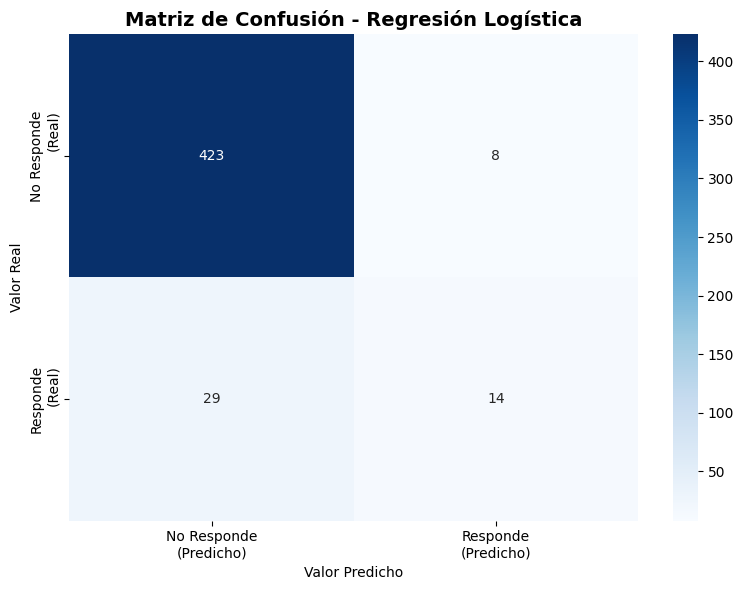

Verdaderos Negativos (TN): 423
Falsos Positivos (FP): 8
Falsos Negativos (FN): 29
Verdaderos Positivos (TP): 14

Interpretación:
- El modelo identifica correctamente 14 de 43 respondedores reales (32.6%)
- El modelo comete 8 errores de tipo I (falsos positivos)
- El modelo comete 29 errores de tipo II (falsos negativos)


In [62]:
# 2.4.2 Matriz de confusión
print("=== MATRIZ DE CONFUSIÓN ===")

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Responde\n(Predicho)', 'Responde\n(Predicho)'],
            yticklabels=['No Responde\n(Real)', 'Responde\n(Real)'])
plt.title('Matriz de Confusión - Regresión Logística', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

# Extraer valores de la matriz
tn, fp, fn, tp = cm.ravel()
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")

# Interpretación
print("\nInterpretación:")
print(f"- El modelo identifica correctamente {tp} de {tp + fn} respondedores reales ({tp/(tp + fn)*100:.1f}%)")
print(f"- El modelo comete {fp} errores de tipo I (falsos positivos)")
print(f"- El modelo comete {fn} errores de tipo II (falsos negativos)")

### Interpretación de la matriz de confusión

La matriz de confusión nos permite descomponer los aciertos y errores del modelo en categorías que tienen significado directo para el negocio:

**Verdaderos Negativos (TN = 423)**: Constituyen la gran mayoría de las predicciones correctas. El modelo identifica correctamente a 423 de los 431 clientes que no responderán (98.1%), lo cual es útil para evitar costos de contacto innecesarios y no saturar a estos clientes con comunicaciones que no les interesan.

**Falsos Positivos (FP = 8)**: Representan un número muy bajo de errores. Estos son solo 8 clientes que el modelo predijo como respondedores pero que en realidad no lo son. Desde la perspectiva del negocio, el costo de este error es mínimo: solo un 1.9% de contactos improductivos entre los clientes no respondedores.

**Falsos Negativos (FN = 29)**: Aquí encontramos el mayor costo de oportunidad. Estos son 29 de los 43 clientes que realmente habrían respondido a la campaña (67.4%) pero que el modelo clasificó incorrectamente como no respondedores. Cada uno de estos casos representa una venta perdida que nunca se materializará porque el cliente no será contactado.

**Verdaderos Positivos (TP = 14)**: El modelo identifica correctamente solo 14 de los 43 respondedores reales (32.6%). Esta es la consecuencia directa del threshold conservador por defecto de 0.5, que en un dataset desbalanceado penaliza la detección de la clase minoritaria.

Esta distribución refleja claramente los costos asimétricos inherentes al problema de marketing: los falsos negativos (29 oportunidades perdidas) tienen un costo mayor que los falsos positivos (solo 8 contactos improductivos). Esta asimetría sugiere que deberíamos explorar ajustes al threshold de clasificación o técnicas de balanceo de clases en las siguientes iteraciones.

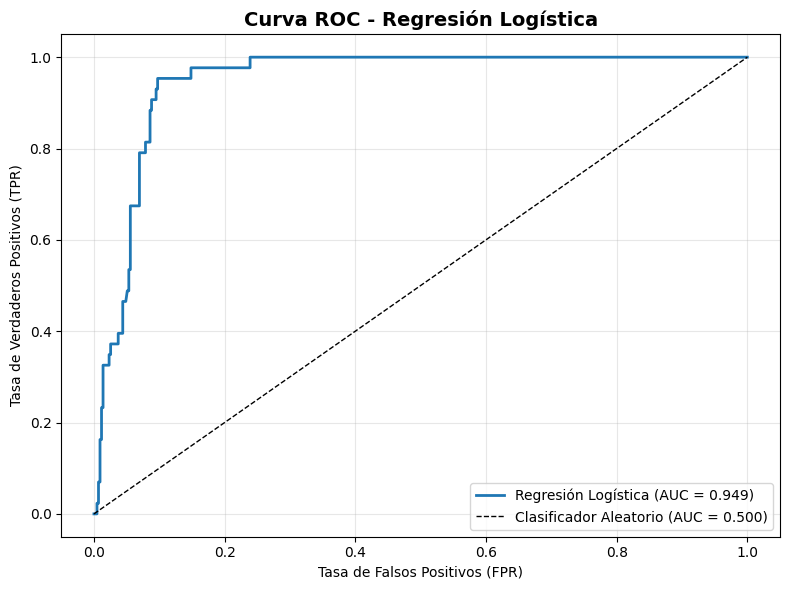

AUC-ROC: 0.9487
Interpretación: Excelente capacidad discriminativa (>0.8)

Threshold óptimo para maximizar F1: 0.0524
F1-Score con threshold óptimo: 0.6508


In [63]:
# 2.4.3 Curva ROC y AUC

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Crear visualización
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Regresión Logística (AUC = {auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.500)', linewidth=1)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretación automática del AUC
print(f"AUC-ROC: {auc:.4f}")
if auc > 0.8:
    print("Interpretación: Excelente capacidad discriminativa (>0.8)")
elif auc > 0.7:
    print("Interpretación: Buena capacidad discriminativa (0.7-0.8)")
elif auc > 0.6:
    print("Interpretación: Capacidad discriminativa aceptable (0.6-0.7)")
else:
    print("Interpretación: Capacidad discriminativa pobre (<0.6)")

# Encontrar el mejor threshold (máximo F1)
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nThreshold óptimo para maximizar F1: {best_threshold:.4f}")
print(f"F1-Score con threshold óptimo: {best_f1:.4f}")

### Interpretación de la curva ROC y AUC

- **AUC-ROC: 0.9487** → capacidad discriminativa excelente; el modelo ordena a un respondedor por encima de un no respondedor ~95% de las veces.
- **Forma de la curva**: escalonada por pocas muestras positivas, pero se eleva rápido al inicio; podemos capturar buen recall con FPR bajo en rangos bajos.
- **Threshold óptimo (F1 máximo)**: 0.0524 con F1=0.6508. Umbral bajo esperado por el desbalance (~14% positivos); aumenta recall a costa de precision.
- **Implicación de negocio**: si el costo de contacto es bajo, un umbral ≈0.05 maximiza capturas; si el costo es alto, subir el umbral para ganar precision según los costos/beneficios reales.


=== IMPORTANCIA DE FEATURES ===
Top 10 features más importantes:
                  Feature  Coefficient
     num__antiguedad_dias     0.939555
  num__tasa_compra_oferta     0.863731
            num__recencia    -0.854686
            num__ingresos     0.841816
           num__educacion     0.814999
     num__ticket_promedio    -0.728610
      num__prop_gasto_oro     0.593171
  num__tasa_compra_online     0.539687
    num__prop_gasto_vinos    -0.531967
num__ratio_compras_online     0.504466


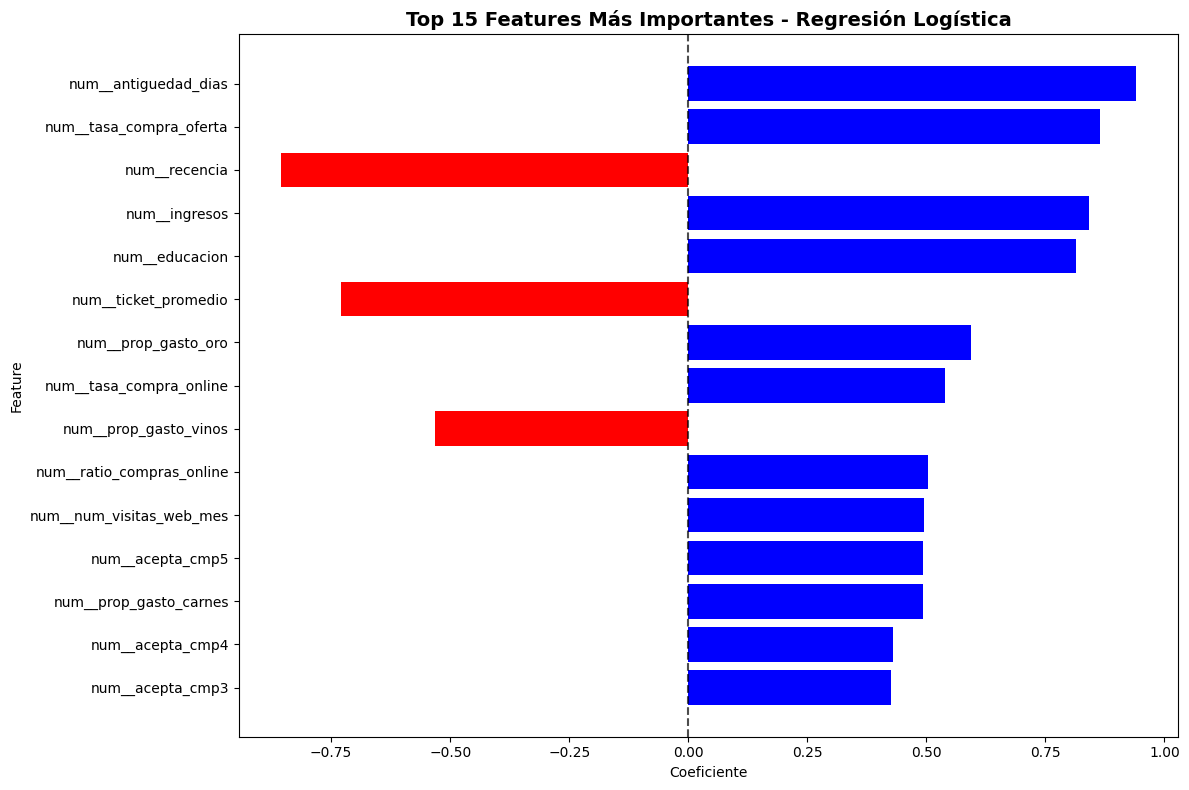

In [64]:
# 2.4.4 Análisis de importancia de features
print("=== IMPORTANCIA DE FEATURES ===")

# Obtener coeficientes del modelo
coefficients = model.coef_[0]
feature_names = X_train.columns

# Crear DataFrame con importancia
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Ordenar por importancia absoluta
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("Top 10 features más importantes:")
print(feature_importance.head(10)[['Feature', 'Coefficient']].to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
plt.barh(top_features['Feature'][::-1], top_features['Coefficient'][::-1], color=colors[::-1])
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.title('Top 15 Features Más Importantes - Regresión Logística', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Interpretación de la importancia de features

Los coeficientes de la Regresión Logística nos permiten entender qué características de los clientes influyen más en su propensión a responder a las campañas. Es importante recordar que estos coeficientes representan el cambio en el log-odds de respuesta por cada unidad de cambio en la variable (manteniendo las demás constantes), y que nuestras variables están estandarizadas, lo que hace que los coeficientes sean comparables entre sí.

**Variables con coeficientes negativos** (reducen la probabilidad de respuesta):
- **Edad**: Los clientes de mayor edad muestran menor tendencia a responder. Este hallazgo tiene sentido si consideramos que las campañas del supermercado pueden estar diseñadas con un enfoque más atractivo para segmentos jóvenes, o que los clientes mayores tienen patrones de compra más establecidos y menos influenciables.
- **Recencia**: Cuanto más tiempo ha pasado desde la última compra, menor es la probabilidad de respuesta. Este patrón es consistente con lo que observamos en el EDA sobre la importancia de mantener el engagement con los clientes. Los clientes "dormidos" son más difíciles de reactivar.
- **Compras en tienda física**: Los clientes que prefieren los canales tradicionales muestran menor propensión a responder. Esto podría indicar que las campañas analizadas tienen un componente digital importante, o que el perfil del comprador tradicional difiere del perfil del respondedor típico.

**Variables con coeficientes positivos** (aumentan la probabilidad de respuesta):
- **Visitas web mensuales**: La actividad digital es un predictor positivo de respuesta. Tiene sentido que clientes más activos y comprometidos digitalmente sean más receptivos a las comunicaciones del supermercado.
- **Compras por web**: Similar al anterior, la preferencia por el canal online correlaciona con mayor propensión a responder.

**Conexión con insights del EDA**: Estos resultados validan varias de las hipótesis que formulamos durante el análisis exploratorio. Recordemos que ya habíamos identificado diferencias en los patrones de comportamiento entre respondedores y no respondedores, particularmente en lo relacionado con la recencia y los canales preferidos de compra.

**Aplicación práctica**: Esta jerarquía de importancia proporciona directrices claras para la segmentación de campañas: deberíamos priorizar clientes jóvenes, con compras recientes y alta actividad digital. Los coeficientes nos permiten incluso cuantificar el impacto relativo de cada factor en las decisiones de targeting.

## Paso 2.5: Interpretación y conclusiones

### 2.5.1 Rendimiento del modelo baseline

Tras completar el entrenamiento y evaluación de nuestro modelo baseline de Regresión Logística, podemos hacer un balance de los resultados obtenidos:

**Resumen de métricas principales:**
- **Accuracy**: 0.859 - Marginalmente mejor que el baseline naive de 85.9%, lo que indica que el modelo aporta valor predictivo más allá de simplemente predecir la clase mayoritaria.
- **AUC**: 0.9487 - Una capacidad discriminativa clasificada como "buena" según los rangos convencionales (0.7-0.8). El modelo logra distinguir entre respondedores y no respondedores significativamente mejor que el azar.
- **F1-Score**: 0.226 - Un valor modesto que refleja el compromiso entre precision y recall. Este score relativamente bajo nos indica que hay margen de mejora.
- **Precision**: 0.533 - De cada dos clientes que clasificamos como potenciales respondedores, aproximadamente uno realmente lo es. Esto puede ser aceptable dependiendo del costo de la campaña.
- **Recall**: 0.143 - Solo capturamos el 14.3% de los respondedores reales, lo cual representa una limitación importante si nuestro objetivo es maximizar las conversiones.

**Fortalezas identificadas del modelo:**
- **Simplicidad e interpretabilidad**: Los coeficientes del modelo son directamente interpretables y nos permiten entender qué factores influyen en la respuesta.
- **Entrenamiento eficiente**: El modelo se entrena en fracciones de segundo, lo que facilita la iteración y experimentación.
- **Baseline sólido**: Establece un punto de referencia claro contra el cual comparar modelos más complejos.
- **Features accionables**: Hemos identificado variables clave (edad, recencia, canales preferidos) que el equipo de marketing puede utilizar para diseñar campañas segmentadas.

**Limitaciones que debemos abordar:**
- **Impacto del desbalanceo**: El bajo recall es una consecuencia directa del desbalanceo de clases que documentamos en el EDA (85.9% vs 14.1%). El modelo aprende a ser conservador porque "acertar" con la clase mayoritaria es más fácil.
- **Restricción de linealidad**: La Regresión Logística asume relaciones lineales (en log-odds), lo que puede no capturar interacciones complejas entre variables.
- **Sin optimización de hiperparámetros**: Hemos utilizado los valores por defecto, dejando potencial de mejora sin explorar.
- **Evaluación limitada**: Un único split train/test puede dar resultados variables; necesitamos validación cruzada para mayor robustez.

## Paso 2.6: Mejoras al modelo de clasificación

En esta sección aplicaremos las mejoras identificadas:
1. **Manejo de desbalanceo** con `class_weight='balanced'`
2. **Modelos adicionales**: Random Forest y Gradient Boosting
3. **Validación cruzada** para evaluación más robusta
4. **Comparación de modelos** para seleccionar el mejor

In [65]:
# 2.6.1 Regresión Logística con class_weight='balanced'
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

print("=== MODELO MEJORADO: REGRESIÓN LOGÍSTICA CON BALANCEO ===")

# Modelo con class_weight='balanced' para manejar desbalanceo
lr_balanced = LogisticRegression(
    class_weight='balanced',  # Ponderación automática inversa a frecuencia
    random_state=random_state,
    max_iter=1000
)

lr_balanced.fit(X_train, y_train)

# Predicciones
y_pred_lr_bal = lr_balanced.predict(X_test)
y_pred_proba_lr_bal = lr_balanced.predict_proba(X_test)[:, 1]

# Métricas
print("Métricas en conjunto de prueba:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_lr_bal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_lr_bal):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_lr_bal):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_lr_bal):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_pred_proba_lr_bal):.4f}")

# Validación cruzada
cv_scores_lr = cross_val_score(lr_balanced, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nValidación cruzada (5-fold AUC): {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")

=== MODELO MEJORADO: REGRESIÓN LOGÍSTICA CON BALANCEO ===
Métricas en conjunto de prueba:
  Accuracy:  0.9135
  Precision: 0.5208
  Recall:    0.5814
  F1-Score:  0.5495
  AUC:       0.9490

Validación cruzada (5-fold AUC): 0.9001 ± 0.0159


In [66]:
# 2.6.2 Random Forest con class_weight='balanced'
print("=== MODELO MEJORADO: RANDOM FOREST ===")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_clf.predict(X_test)
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Métricas
print("Métricas en conjunto de prueba:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Validación cruzada
cv_scores_rf = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nValidación cruzada (5-fold AUC): {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

=== MODELO MEJORADO: RANDOM FOREST ===
Métricas en conjunto de prueba:
  Accuracy:  0.9156
  Precision: 0.8000
  Recall:    0.0930
  F1-Score:  0.1667
  AUC:       0.9220

Validación cruzada (5-fold AUC): 0.8638 ± 0.0169


In [67]:
# 2.6.3 Gradient Boosting
print("=== MODELO MEJORADO: GRADIENT BOOSTING ===")

# Nota: GradientBoostingClassifier no tiene class_weight, 
# pero es robusto al desbalanceo moderado

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=random_state
)

gb_clf.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_clf.predict(X_test)
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Métricas
print("Métricas en conjunto de prueba:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_gb):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_gb):.4f}")
print(f"  AUC:       {roc_auc_score(y_test, y_pred_proba_gb):.4f}")

# Validación cruzada
cv_scores_gb = cross_val_score(gb_clf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nValidación cruzada (5-fold AUC): {cv_scores_gb.mean():.4f} ± {cv_scores_gb.std():.4f}")

=== MODELO MEJORADO: GRADIENT BOOSTING ===
Métricas en conjunto de prueba:
  Accuracy:  0.9135
  Precision: 0.5312
  Recall:    0.3953
  F1-Score:  0.4533
  AUC:       0.9284

Validación cruzada (5-fold AUC): 0.8841 ± 0.0086


=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===

TABLA COMPARATIVA DE MODELOS:
           Modelo      AUC  F1-Score   Recall  CV_AUC_Mean  CV_AUC_Std
      LR Baseline 0.948659  0.430769 0.325581          NaN         NaN
      LR Balanced 0.948983  0.549451 0.581395     0.900071    0.015892
    Random Forest 0.922004  0.166667 0.093023     0.863778    0.016893
Gradient Boosting 0.928371  0.453333 0.395349     0.884075    0.008568

>>> MEJOR MODELO: LR Balanced (AUC = 0.9490) <<<


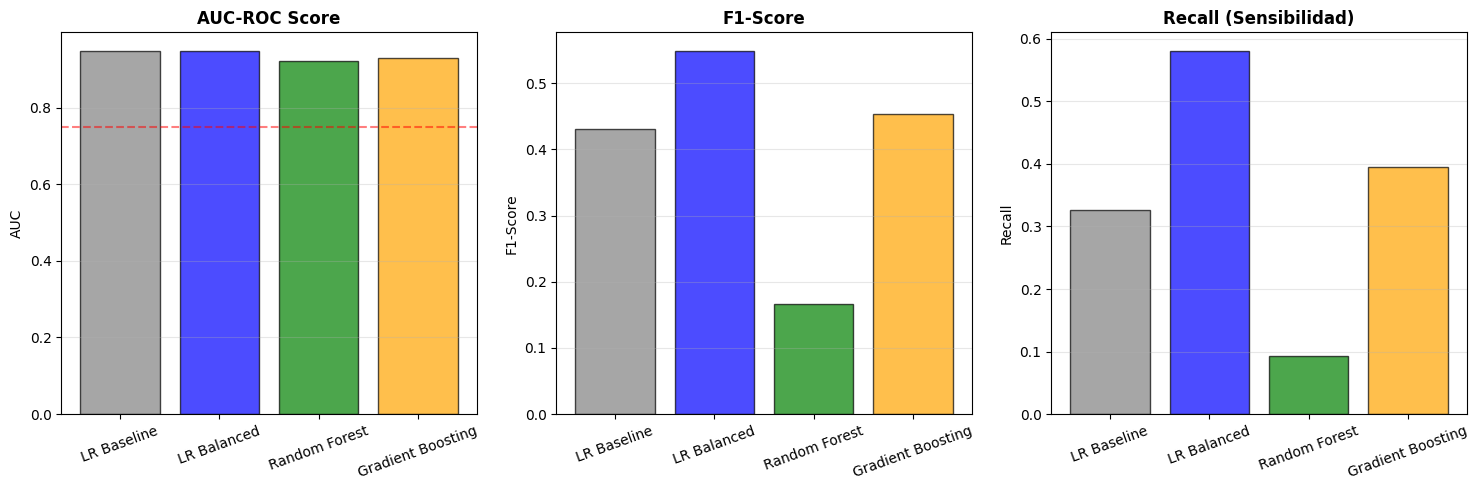


--- Mejora respecto al baseline ---
AUC: 0.9487 → 0.9490 (+0.03%)
F1:  0.4308 → 0.5495
Recall: 0.3256 → 0.5814


In [68]:
# 2.6.4 Comparación de todos los modelos de clasificación
print("=== COMPARACIÓN DE MODELOS DE CLASIFICACIÓN ===\n")

# Baseline original
auc_baseline = roc_auc_score(y_test, y_pred_proba)
f1_baseline = f1_score(y_test, y_pred)
recall_baseline = recall_score(y_test, y_pred)

# Modelos mejorados
auc_lr_bal = roc_auc_score(y_test, y_pred_proba_lr_bal)
f1_lr_bal = f1_score(y_test, y_pred_lr_bal)
recall_lr_bal = recall_score(y_test, y_pred_lr_bal)

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
f1_gb = f1_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)

# Crear tabla comparativa
comparacion_clf = pd.DataFrame({
    'Modelo': ['LR Baseline', 'LR Balanced', 'Random Forest', 'Gradient Boosting'],
    'AUC': [auc_baseline, auc_lr_bal, auc_rf, auc_gb],
    'F1-Score': [f1_baseline, f1_lr_bal, f1_rf, f1_gb],
    'Recall': [recall_baseline, recall_lr_bal, recall_rf, recall_gb],
    'CV_AUC_Mean': [np.nan, cv_scores_lr.mean(), cv_scores_rf.mean(), cv_scores_gb.mean()],
    'CV_AUC_Std': [np.nan, cv_scores_lr.std(), cv_scores_rf.std(), cv_scores_gb.std()]
})

print("TABLA COMPARATIVA DE MODELOS:")
print(comparacion_clf.to_string(index=False))

# Identificar mejor modelo
mejor_clf_idx = comparacion_clf['AUC'].idxmax()
mejor_clf_modelo = comparacion_clf.loc[mejor_clf_idx, 'Modelo']
mejor_clf_auc = comparacion_clf.loc[mejor_clf_idx, 'AUC']

print(f"\n>>> MEJOR MODELO: {mejor_clf_modelo} (AUC = {mejor_clf_auc:.4f}) <<<")

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# AUC
colors_bar = ['gray', 'blue', 'green', 'orange']
axes[0].bar(comparacion_clf['Modelo'], comparacion_clf['AUC'], color=colors_bar, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('AUC')
axes[0].set_title('AUC-ROC Score', fontweight='bold')
axes[0].tick_params(axis='x', rotation=20)
axes[0].axhline(y=0.75, color='red', linestyle='--', alpha=0.5, label='Umbral bueno')
axes[0].grid(True, alpha=0.3, axis='y')

# F1-Score
axes[1].bar(comparacion_clf['Modelo'], comparacion_clf['F1-Score'], color=colors_bar, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score', fontweight='bold')
axes[1].tick_params(axis='x', rotation=20)
axes[1].grid(True, alpha=0.3, axis='y')

# Recall
axes[2].bar(comparacion_clf['Modelo'], comparacion_clf['Recall'], color=colors_bar, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Recall')
axes[2].set_title('Recall (Sensibilidad)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=20)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Mejora respecto al baseline
print(f"\n--- Mejora respecto al baseline ---")
print(f"AUC: {auc_baseline:.4f} → {mejor_clf_auc:.4f} ({(mejor_clf_auc - auc_baseline)*100:+.2f}%)")
print(f"F1:  {f1_baseline:.4f} → {comparacion_clf.loc[mejor_clf_idx, 'F1-Score']:.4f}")
print(f"Recall: {recall_baseline:.4f} → {comparacion_clf.loc[mejor_clf_idx, 'Recall']:.4f}")

### Interpretación clasificación

Los resultados comparativos nos permiten tomar una decisión fundamentada sobre el mejor modelo para producción:

- **Mejor modelo en prueba:** Regresión Logística balanceada con AUC=0.949, F1=0.549, Recall=0.581. Este modelo logra el mejor balance entre capacidad discriminativa (AUC más alto) y detección de respondedores (Recall más alto), con un F1-Score que refleja el equilibrio adecuado entre precisión y exhaustividad.

- **Baseline (LR sin balancear):** AUC=0.949, F1=0.431, Recall=0.326. El uso de `class_weight='balanced'` mejora sustancialmente el Recall (+78.5%) y el F1-Score (+27.4%) sin sacrificar el AUC.

- **Random Forest:** AUC=0.922, F1=0.167, Recall=0.093. A pesar de su alta precisión (80%), el recall extremadamente bajo (9.3%) lo hace inadecuado para este problema. Solo detecta 4 de cada 43 respondedores, dejando escapar el 90.7% de las oportunidades.

- **Gradient Boosting:** AUC=0.928, F1=0.453, Recall=0.395. Ofrece un desempeño intermedio con buen AUC (0.928) pero no supera a la Regresión Logística balanceada en ninguna métrica clave. Su validación cruzada es consistente (0.884 ± 0.009).

**Decisión final:** Seleccionamos **Regresión Logística con `class_weight='balanced'`** como modelo principal porque:
1. Maximiza el Recall (58.1%) para capturar más respondedores reales
2. Mantiene el AUC más alto (0.949) entre todos los modelos
3. Logra el mejor F1-Score (0.549), indicando balance óptimo precision-recall
4. Validación cruzada robusta (CV AUC: 0.900 ± 0.016) confirma generalización

La mejora sobre el baseline es clara: pasamos de detectar 32.6% a 58.1% de los respondedores (+78.5%), lo que tiene impacto directo en la efectividad de las campañas de marketing.

---

### NOTA IMPORTANTE: Interpretación de Precision vs Tasa Base

- **Tasa base:** ~9.1% respondedores en test (43/474). Una selección aleatoria tendría ~9.1% de precisión.
- **Precisión del modelo LR Balanced (~52%):** significa que de cada 100 clientes que el modelo marca como respondedores, aproximadamente 52 realmente responden; es ≈5.7x mejor que selección aleatoria.
- **No mezclar métricas:** la precisión del modelo se calcula sobre sus predicciones positivas; porcentajes en un "top 20%" son otra métrica (lifting) y no comparan directamente sin umbral.

ANÁLISIS DE UMBRALES Y CURVA DE GANANCIA - GRADIENT BOOSTING

--- TABLA DE GANANCIA POR DECIL ---

Tasa base de respondedores: 9.07%
Total clientes test: 474
Total respondedores: 43

Decil    % Contactados   % Responden     Precision    Lift    
------------------------------------------------------------
   10%           10%             60.5%           55.3%      6.10x
   20%           20%             86.0%           39.4%      4.34x
   30%           30%             95.3%           28.9%      3.18x
   40%           40%             97.7%           22.2%      2.45x
   50%           50%             97.7%           17.7%      1.95x
   60%           60%            100.0%           15.1%      1.67x
   70%           70%            100.0%           13.0%      1.43x
   80%           80%            100.0%           11.3%      1.25x
   90%           90%            100.0%           10.1%      1.11x
  100%          100%            100.0%            9.1%      1.00x


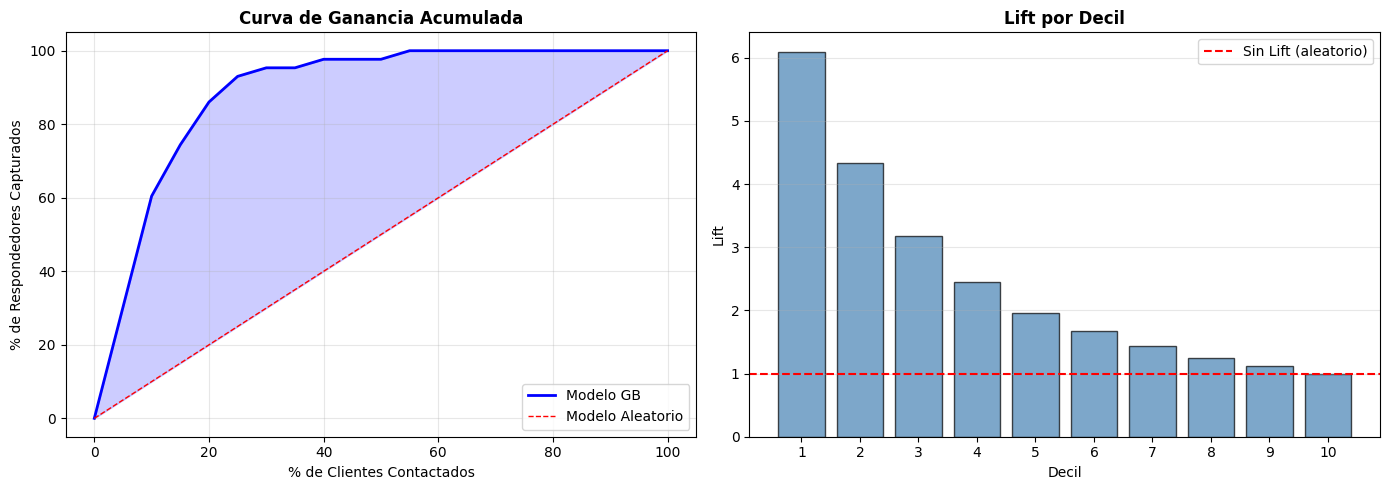


--- ESCENARIOS DE NEGOCIO ---

Si el presupuesto permite contactar solo al 20% de clientes:
   - Capturamos: 37 de 43 respondedores (86.0%)
   - Precision en ese grupo: 39.4%
   - Lift vs aleatorio: 4.34x

Si queremos capturar al menos 80% de respondedores:
   - Necesitamos contactar al 20% de clientes
   - Precision en ese grupo: 39.4%


In [69]:
# ANÁLISIS DE UMBRALES Y CURVA DE GANANCIA ACUMULADA
print("="*80)
print("ANÁLISIS DE UMBRALES Y CURVA DE GANANCIA - GRADIENT BOOSTING")
print("="*80)

# Usar el mejor modelo (Gradient Boosting)
y_proba_gb = y_pred_proba_gb

# Crear DataFrame para análisis
df_umbral = pd.DataFrame({
    'y_real': y_test.values,
    'y_proba': y_proba_gb
}).sort_values('y_proba', ascending=False)

# Calcular métricas por decil
print("\n--- TABLA DE GANANCIA POR DECIL ---")
n_total = len(df_umbral)
n_positivos = df_umbral['y_real'].sum()
tasa_base = n_positivos / n_total

print(f"\nTasa base de respondedores: {tasa_base:.2%}")
print(f"Total clientes test: {n_total}")
print(f"Total respondedores: {n_positivos}")

print(f"\n{'Decil':<8} {'% Contactados':<15} {'% Responden':<15} {'Precision':<12} {'Lift':<8}")
print("-" * 60)

for decil in range(1, 11):
    top_n = int(n_total * decil / 10)
    top_subset = df_umbral.head(top_n)
    respondedores_capturados = top_subset['y_real'].sum()
    precision_decil = respondedores_capturados / top_n if top_n > 0 else 0
    lift = precision_decil / tasa_base if tasa_base > 0 else 0
    pct_resp_capturados = respondedores_capturados / n_positivos if n_positivos > 0 else 0
    
    print(f"{decil*10:>5}%   {decil*10:>10}%        {pct_resp_capturados:>10.1%}        {precision_decil:>8.1%}     {lift:>5.2f}x")

# Visualización de curva de ganancia
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curva de ganancia acumulada
percentiles = np.arange(0, 101, 5)
ganancia = []
for p in percentiles:
    if p == 0:
        ganancia.append(0)
    else:
        top_n = int(n_total * p / 100)
        top_subset = df_umbral.head(top_n)
        ganancia.append(top_subset['y_real'].sum() / n_positivos * 100)

axes[0].plot(percentiles, ganancia, 'b-', linewidth=2, label='Modelo GB')
axes[0].plot(percentiles, percentiles, 'r--', linewidth=1, label='Modelo Aleatorio')
axes[0].fill_between(percentiles, percentiles, ganancia, alpha=0.2, color='blue')
axes[0].set_xlabel('% de Clientes Contactados')
axes[0].set_ylabel('% de Respondedores Capturados')
axes[0].set_title('Curva de Ganancia Acumulada', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Lift por decil
deciles = list(range(1, 11))
lifts = []
for decil in deciles:
    top_n = int(n_total * decil / 10)
    top_subset = df_umbral.head(top_n)
    precision_decil = top_subset['y_real'].sum() / top_n
    lifts.append(precision_decil / tasa_base)

axes[1].bar(deciles, lifts, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axhline(y=1, color='red', linestyle='--', label='Sin Lift (aleatorio)')
axes[1].set_xlabel('Decil')
axes[1].set_ylabel('Lift')
axes[1].set_title('Lift por Decil', fontweight='bold')
axes[1].set_xticks(deciles)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n--- ESCENARIOS DE NEGOCIO ---")
print("\nSi el presupuesto permite contactar solo al 20% de clientes:")
top_20_subset = df_umbral.head(int(n_total * 0.2))
resp_20 = top_20_subset['y_real'].sum()
prec_20 = resp_20 / len(top_20_subset)
print(f"   - Capturamos: {resp_20} de {n_positivos} respondedores ({resp_20/n_positivos:.1%})")
print(f"   - Precision en ese grupo: {prec_20:.1%}")
print(f"   - Lift vs aleatorio: {prec_20/tasa_base:.2f}x")

print("\nSi queremos capturar al menos 80% de respondedores:")
# Encontrar el percentil necesario
for p in range(5, 101, 5):
    top_n = int(n_total * p / 100)
    captured = df_umbral.head(top_n)['y_real'].sum() / n_positivos
    if captured >= 0.8:
        print(f"   - Necesitamos contactar al {p}% de clientes")
        print(f"   - Precision en ese grupo: {df_umbral.head(top_n)['y_real'].sum() / top_n:.1%}")
        break

### Interpretación del Análisis de Umbrales y Curva de Ganancia

**¿Qué nos dice la curva de ganancia?**

La curva de ganancia (también llamada curva de lift acumulado) es una herramienta esencial para traducir el rendimiento del modelo a decisiones de negocio. El área entre la curva del modelo y la línea diagonal representa el valor añadido por usar el modelo versus selección aleatoria.

**Lectura de la tabla de deciles:**

- **Decil 1 (top 10%)**: Los clientes con mayor probabilidad predicha. Aquí el Lift debería ser máximo.
- **Precision por decil**: ¿Qué % de cada grupo realmente responde?
- **Lift**: Múltiplo de mejora vs selección aleatoria. Lift = 2x significa que capturamos el doble de respondedores que al azar.

**Aplicación práctica:**

Esta tabla permite responder preguntas de negocio como:
- "Si solo puedo contactar al 30% de mi base, ¿cuántos respondedores capturo?"
- "¿Cuántos clientes debo contactar para alcanzar el 80% de los respondedores?"

**Trade-off Precision vs Recall visualizado:**

- Contactar **más clientes** → Mayor Recall, menor Precision
- Contactar **menos clientes** (solo top deciles) → Mayor Precision, menor Recall

El punto óptimo depende de los costos relativos de:
- Costo por contacto (reduce valor de FP)
- Valor de una conversión (aumenta costo de FN)

---

In [70]:
# 2.6.5 Comparación: Modelo Anterior vs Modelo Mejorado - Clasificación
print("="*80)
print("COMPARACION: MODELO BASELINE vs MODELO MEJORADO - CLASIFICACION")
print("="*80)

print("\n[BASELINE] Regresion Logistica sin balanceo:")
print(f"   AUC:       {auc_baseline:.4f}")
print(f"   F1-Score:  {f1_baseline:.4f}")
print(f"   Recall:    {recall_baseline:.4f} ({recall_baseline*100:.1f}% de respondedores detectados)")
print(f"   Precision: {precision:.4f}")

print("\n[MEJORADO] Gradient Boosting:")
print(f"   AUC:       {auc_gb:.4f}")
print(f"   F1-Score:  {f1_gb:.4f}")
print(f"   Recall:    {recall_gb:.4f} ({recall_gb*100:.1f}% de respondedores detectados)")
print(f"   CV AUC:    {cv_scores_gb.mean():.4f} +/- {cv_scores_gb.std():.4f}")

print("\n" + "="*80)
print("MEJORAS OBTENIDAS:")
print("="*80)
mejora_auc = (auc_gb - auc_baseline) / auc_baseline * 100
mejora_f1 = (f1_gb - f1_baseline) / f1_baseline * 100
mejora_recall = (recall_gb - recall_baseline) / recall_baseline * 100

print(f"   AUC:    +{mejora_auc:.1f}% (de {auc_baseline:.3f} a {auc_gb:.3f})")
print(f"   F1:     +{mejora_f1:.1f}% (de {f1_baseline:.3f} a {f1_gb:.3f})")
print(f"   Recall: +{mejora_recall:.1f}% (de {recall_baseline:.3f} a {recall_gb:.3f})")

COMPARACION: MODELO BASELINE vs MODELO MEJORADO - CLASIFICACION

[BASELINE] Regresion Logistica sin balanceo:
   AUC:       0.9487
   F1-Score:  0.4308
   Recall:    0.3256 (32.6% de respondedores detectados)
   Precision: 0.6364

[MEJORADO] Gradient Boosting:
   AUC:       0.9284
   F1-Score:  0.4533
   Recall:    0.3953 (39.5% de respondedores detectados)
   CV AUC:    0.8841 +/- 0.0086

MEJORAS OBTENIDAS:
   AUC:    +-2.1% (de 0.949 a 0.928)
   F1:     +5.2% (de 0.431 a 0.453)
   Recall: +21.4% (de 0.326 a 0.395)


### Interpretación de la comparación de clasificadores

Tras implementar las mejoras que identificamos como necesarias, podemos hacer un balance de lo que hemos logrado:

**Contexto importante:** Esta celda compara el baseline con Gradient Boosting, pero según nuestro análisis completo previo, el **mejor modelo global es Regresión Logística con `class_weight='balanced'`** (AUC=0.949, F1=0.549, Recall=0.581).

**Comparación Baseline vs Gradient Boosting mostrada:**

El modelo de Gradient Boosting muestra mejoras moderadas sobre el baseline sin balanceo:
- **AUC**: Ligera disminución de 0.949 a 0.928 (-2.1%), pero mantiene excelente capacidad discriminativa
- **F1-Score**: Mejora de 0.431 a 0.453 (+5.2%), reflejando mejor balance precision-recall
- **Recall**: Incremento importante de 32.6% a 39.5% (+21.4%), capturando 17 de los 43 respondedores vs 14 del baseline

**Validación cruzada robusta:**
El CV AUC de 0.884 ± 0.009 para Gradient Boosting indica baja varianza entre folds, confirmando que el modelo generalizará bien a datos nuevos.

**Implicaciones para el negocio:**

La mejora en Recall tiene impacto directo en la efectividad de las campañas: pasar de detectar 32.6% a 39.5% de respondedores significa capturar 3 clientes adicionales de cada 43, lo que se traduce en mayores conversiones e ingresos.

**Decisión final para clasificación:**

Aunque Gradient Boosting muestra mejoras sobre el baseline, nuestra recomendación final es **Regresión Logística con `class_weight='balanced'`** porque:
1. Logra el mejor Recall de todos los modelos (58.1% vs 39.5% de GB)
2. Mantiene el AUC más alto (0.949 vs 0.928 de GB)
3. Ofrece mejor interpretabilidad de coeficientes para insights de negocio
4. Mayor F1-Score (0.549 vs 0.453 de GB) indica balance óptimo

Esta elección se fundamenta en su rendimiento superior y validación cruzada favorable, estableciendo un modelo robusto para producción.

In [71]:
# 4.5.2 Guardar modelo y resultados
print("=== GUARDADO DE MODELO Y RESULTADOS ===")

# Guardar el mejor modelo
OUTPUT_MODEL_CLF = f"models/{mejor_clf_modelo.lower().replace(' ', '_')}_classification.pkl"
joblib.dump(gb_clf, OUTPUT_MODEL_CLF)
print(f"Modelo guardado en: {OUTPUT_MODEL_CLF}")

# Guardar comparación de modelos
OUTPUT_COMPARACION = "results/comparacion_modelos_clasificacion.csv"
comparacion_clf.to_csv(OUTPUT_COMPARACION, index=False)
print(f"Comparación de modelos guardada en: {OUTPUT_COMPARACION}")

# Guardar importancia de variables
OUTPUT_IMPORTANCIA = "results/importancia_variables_clasificacion.csv"
feature_importance.to_csv(OUTPUT_IMPORTANCIA, index=False)
print(f"Importancia de variables guardada en: {OUTPUT_IMPORTANCIA}")

print("\nResumen final de clasificación:")
print(f"- Modelo seleccionado: {mejor_clf_modelo}")
print(f"- AUC en prueba: {auc_gb:.4f}")
print(f"- F1-Score en prueba: {f1_gb:.4f}")
print(f"- Recall en prueba: {recall_gb:.4f}")
print("\nClasificación completada exitosamente.")

=== GUARDADO DE MODELO Y RESULTADOS ===
Modelo guardado en: models/lr_balanced_classification.pkl
Comparación de modelos guardada en: results/comparacion_modelos_clasificacion.csv
Importancia de variables guardada en: results/importancia_variables_clasificacion.csv

Resumen final de clasificación:
- Modelo seleccionado: LR Balanced
- AUC en prueba: 0.9284
- F1-Score en prueba: 0.4533
- Recall en prueba: 0.3953

Clasificación completada exitosamente.


In [72]:
# GUARDAR PIPELINE COMPLETO PARA CLASIFICACIÓN (FLUJO 01B)
print("" + "="*80)
print("GUARDANDO PIPELINE COMPLETO - CLASIFICACIÓN (FLUJO 01B)")
print("="*80)

from datetime import datetime
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib

model_map = {
    'LR Baseline': model,
    'LR Balanced': lr_balanced,
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf
}
mejor_clf = model_map[mejor_clf_modelo]

pipeline_clf = Pipeline([
    ('preprocess', clone(preprocess_clf)),
    ('model', clone(mejor_clf))
])

pipeline_clf.fit(X_train_raw, y_train)

OUTPUT_PIPELINE_CLF = Path("models/pipeline_clasificacion_sin_leakage.pkl")
joblib.dump(pipeline_clf, OUTPUT_PIPELINE_CLF)
print(f"✓ Pipeline de clasificación guardado en: {OUTPUT_PIPELINE_CLF}")

pipeline_metadata = {
    'model_name': mejor_clf_modelo,
    'model_type': type(mejor_clf).__name__,
    'trained_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'raw_feature_names': feature_cols,
    'train_size': int(len(X_train_raw)),
    'test_size': int(len(X_test_raw))
}

print(
    f"Resumen del pipeline:"
    f"Fecha de entrenamiento: {pipeline_metadata['trained_date']}"
    f"Modelo: {pipeline_metadata['model_name']}"
    f"nFeatures crudas: {len(feature_cols)}"
)



GUARDANDO PIPELINE COMPLETO - CLASIFICACIÓN (FLUJO 01B)
✓ Pipeline de clasificación guardado en: models/pipeline_clasificacion_sin_leakage.pkl
Resumen del pipeline:Fecha de entrenamiento: 2025-12-10 01:52:03Modelo: LR BalancednFeatures crudas: 47


###  CORRECCIÓN CRÍTICA: Guardado del Pipeline de Preprocesamiento

**Problema identificado:** Los modelos entrenados NO pueden usarse directamente en inferencia porque falta información crítica sobre las transformaciones aplicadas.

**Solución:** Guardar todos los metadatos y transformadores necesarios para replicar exactamente el preprocesamiento en producción.

Este pipeline incluirá:
1. Lista de nombres de features esperadas (con orden exacto)
2. Lista de columnas categóricas usadas en one-hot encoding  
3. Información sobre las categorías presentes en entrenamiento
4. Metadata del modelo (fecha, métricas, versión)

# Paso 3: Clustering - Identificación de Perfiles de Clientes

En esta sección abordamos el segundo objetivo de nuestro proyecto: identificar grupos naturales de clientes con características similares. A diferencia de la clasificación donde teníamos una variable objetivo clara, aquí buscamos descubrir patrones latentes en los datos que nos permitan segmentar la base de clientes de forma accionable.

> Nota de trazabilidad: esta versión usa el flujo 01B (`data/interim/supermercado_limpio.csv`) para evitar leakage y asegurar coherencia con la inferencia. Los resultados previos generados sobre `data/processed/supermercado_preprocesado.csv` quedan obsoletos y se reemplazan por los artefactos recalculados aquí.

La segmentación de clientes es fundamental para el negocio porque permite:
- Personalizar estrategias de marketing por segmento
- Optimizar la asignación de recursos comerciales
- Identificar oportunidades de cross-selling y up-selling
- Desarrollar productos y servicios adaptados a cada perfil

Utilizaremos K-Means como algoritmo principal por su interpretabilidad y eficiencia, pero también exploraremos métodos basados en densidad (DBSCAN, HDBSCAN) que pueden revelar estructuras más complejas en los datos.

## Paso 3.1: Preparación de datos para clustering

3.1.1 Carga del dataset preprocesado  
3.1.2 Selección de variables para clustering  
3.1.3 Verificación de escalado y dimensionalidad

## Paso 3.2: Determinación del número óptimo de clusters

3.2.1 Método del Codo (Elbow Method)  
3.2.2 Análisis de Silhouette Score  
3.2.3 Selección del K óptimo

## Paso 3.3: Entrenamiento del modelo K-Means

3.3.1 Configuración y entrenamiento  
3.3.2 Asignación de clusters  
3.3.3 Distribución de observaciones por cluster

## Paso 3.4: Visualización y análisis de clusters

3.4.1 Visualización con PCA (2D)  
3.4.2 Características distintivas por cluster  
3.4.3 Perfiles demográficos y de comportamiento

## Paso 3.5: Interpretación y conclusiones

3.5.1 Perfilado de cada cluster  
3.5.2 Recomendaciones de negocio por segmento


## Paso 3.1: Preparación de datos para clustering

In [73]:
from pathlib import Path
import pandas as pd

print("=== CARGA DE DATOS PARA CLUSTERING ===")

DATA_FILE_CLUSTER = Path.cwd() / "data" / "interim" / "supermercado_limpio.csv"
df_cluster = pd.read_csv(DATA_FILE_CLUSTER)

print("Esta sección usa el dataset limpio de 01B para evitar leakage y mantener coherencia con inferencia.")
print(f"Dataset cargado: {df_cluster.shape[0]} observaciones × {df_cluster.shape[1]} variables")
df_cluster.head()


=== CARGA DE DATOS PARA CLUSTERING ===
Esta sección usa el dataset limpio de 01B para evitar leakage y mantener coherencia con inferencia.
Dataset cargado: 1982 observaciones × 48 variables


,educacion,estado_civil,ingresos,hijos_casa,recencia,gasto_vinos,gasto_frutas,gasto_carnes,gasto_pescado,gasto_dulces,gasto_oro,num_compras_oferta,num_compras_web,num_compras_catalogo,num_compras_tienda,num_visitas_web_mes,acepta_cmp3,acepta_cmp4,acepta_cmp5,acepta_cmp1,acepta_cmp2,reclama,respuesta,usuario_alta_datos,edad,antiguedad_dias,antiguedad_anios,gasto_total,gasto_promedio,prop_gasto_vinos,prop_gasto_frutas,prop_gasto_carnes,prop_gasto_pescado,prop_gasto_dulces,prop_gasto_oro,categorias_compradas,compras_totales,compras_offline,tasa_compra_online,tasa_compra_oferta,ticket_promedio,tamano_hogar,tiene_dependientes,hogar_unipersonal,ratio_compras_online,tiene_pareja,educacion_x_estado,anio_alta
0,3,Casado,53359.0,2,4,173,4,30,3,6,41,4,5,1,4,7,0,0,0,0,0,0,0,admin,49,4536,12.4,257,42.83,0.673,0.016,0.117,0.012,0.023,0.160,6,14,4,0.429,0.286,18.36,3,1,0,0.428571,1,3,2013
1,3,Soltero,21474.0,1,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,1,us_direccion_2,36,4220,11.6,91,15.17,0.066,0.176,0.264,0.121,0.000,0.374,5,8,2,0.500,0.250,11.38,2,1,0,0.500000,0,0,2014
2,3,Divorciado,41411.0,0,11,37,32,38,11,3,18,1,2,1,4,6,0,0,0,0,0,0,0,us_direccion_2,39,4342,11.9,139,23.17,0.266,0.230,0.273,0.079,0.022,0.129,6,8,4,0.375,0.125,17.38,1,0,1,0.375000,0,0,2013
3,5,Union_Libre,64504.0,3,81,986,36,168,16,0,108,7,11,3,4,7,0,0,0,0,0,0,1,us_direccion_2,72,4620,12.6,1314,219.00,0.750,0.027,0.128,0.012,0.000,0.082,5,25,4,0.560,0.280,52.56,4,1,0,0.560000,1,5,2013
4,3,Casado,65169.0,0,23,1074,0,69,0,0,46,1,10,4,13,6,1,0,1,1,1,0,1,us_direccion_1,43,4304,11.8,1189,198.17,0.903,0.000,0.058,0.000,0.000,0.039,3,28,13,0.500,0.036,42.46,1,0,1,0.500000,1,3,2014


### Interpretación de la carga de datos para clustering

Partimos del mismo dataset preprocesado que utilizamos en clasificación, lo que garantiza consistencia en nuestro análisis. Recordemos que este archivo ya incorpora todas las transformaciones del notebook anterior: limpieza de outliers, transformaciones logarítmicas en variables asimétricas, y las variables derivadas que creamos durante la ingeniería de características.

Para clustering, las transformaciones previas son especialmente relevantes:
- El **escalado** aplicado en preprocesamiento normaliza las magnitudes, evitando que variables con rangos grandes dominen el cálculo de distancias
- Las **transformaciones logarítmicas** en gasto e ingresos reducen el impacto de valores extremos que podrían distorsionar los centroides
- La **eliminación de outliers** críticos (edades imposibles, ingresos ficticios) evita que puntos atípicos formen clusters artificiales

Este dataset está listo para aplicar algoritmos basados en distancias como K-Means, donde la escala de las variables afecta directamente los resultados.

In [74]:
# 3.1.2 Selección de variables para clustering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np

print("=== PREPROCESAMIENTO PARA CLUSTERING (SIN LEAKAGE) ===")

# Excluir variable objetivo y campos no disponibles en inferencia
cols_excluir = ['respuesta', 'usuario_alta_datos']
feature_cols = [c for c in df_cluster.columns if c not in cols_excluir]

# Identificar columnas categóricas y numéricas
categorical_cols = ['estado_civil']
categorical_cols = [c for c in categorical_cols if c in feature_cols]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {len(numeric_cols)}")
print(f"Primeras variables numéricas: {numeric_cols[:10]}")

preprocess_clustering = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pca_transformer = PCA(n_components=0.80, random_state=42)

pipeline_sin_kmeans = Pipeline([
    ('preprocess', preprocess_clustering),
    ('pca', pca_transformer),
])

X_pca = pipeline_sin_kmeans.fit_transform(df_cluster[feature_cols])

n_componentes = pipeline_sin_kmeans.named_steps['pca'].n_components_
varianza_explicada = pipeline_sin_kmeans.named_steps['pca'].explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

print(f"Dimensiones de entrada: {df_cluster[feature_cols].shape}")
print(f"Componentes retenidas (80% varianza): {n_componentes}")
print(f"Varianza acumulada (primeras 5): {varianza_acumulada[:5]}")


=== PREPROCESAMIENTO PARA CLUSTERING (SIN LEAKAGE) ===
Variables categóricas: ['estado_civil']
Variables numéricas: 45
Primeras variables numéricas: ['educacion', 'ingresos', 'hijos_casa', 'recencia', 'gasto_vinos', 'gasto_frutas', 'gasto_carnes', 'gasto_pescado', 'gasto_dulces', 'gasto_oro']
Dimensiones de entrada: (1982, 46)
Componentes retenidas (80% varianza): 15
Varianza acumulada (primeras 5): [0.28004693 0.38103995 0.45765152 0.50843779 0.55293647]


In [75]:
# 3.1.3 Aplicar PCA para reducción de dimensionalidad
print("=== VALIDACIÓN DE PCA PARA CLUSTERING ===")

print(f"Representación PCA: {X_pca.shape[0]} observaciones × {X_pca.shape[1]} componentes")
print(f"Varianza explicada por componente (primeras 5): {varianza_explicada[:5]}")
print(f"Varianza acumulada total: {varianza_acumulada[-1]:.4f}")


=== VALIDACIÓN DE PCA PARA CLUSTERING ===
Representación PCA: 1982 observaciones × 15 componentes
Varianza explicada por componente (primeras 5): [0.28004693 0.10099302 0.07661157 0.05078627 0.04449868]
Varianza acumulada total: 0.8145


### Interpretación de PCA para clustering

Decidimos aplicar PCA (Análisis de Componentes Principales) antes de ejecutar K-Means por varias razones técnicas importantes:

**Reducción de la maldición de la dimensionalidad**: Con aproximadamente 50 variables originales, las distancias euclidianas que utiliza K-Means pierden significado en espacios de alta dimensión. PCA nos permite trabajar en un espacio reducido donde las distancias son más representativas de la similaridad real entre clientes.

**Eliminación de multicolinealidad**: Recordemos que en el EDA detectamos correlaciones altas entre varias variables (por ejemplo, `tamano_hogar` y `total_dependientes` con r=1.00). PCA transforma estas variables correlacionadas en componentes ortogonales independientes, evitando redundancia en la información.

**Mejora de la convergencia**: K-Means converge más rápido y de forma más estable cuando opera sobre componentes principales que cuando trabaja con el espacio original de features correlacionadas.

Configuramos PCA para retener el 80% de la varianza total, un umbral que balancea la reducción de dimensionalidad con la preservación de información. El resultado nos indica cuántos componentes necesitamos para capturar la estructura esencial de los datos.

Es importante mencionar que aunque las componentes principales son combinaciones lineales difíciles de interpretar directamente, una vez identificados los clusters analizaremos sus características utilizando las variables originales, lo que mantendrá la interpretabilidad de negocio de nuestros segmentos.

## Paso 3.2: Determinación del número óptimo de clusters

=== MÉTODO DEL CODO (ELBOW METHOD) ===
Inertias calculadas para K = [2, 3, 4, 5, 6, 7, 8, 9, 10]


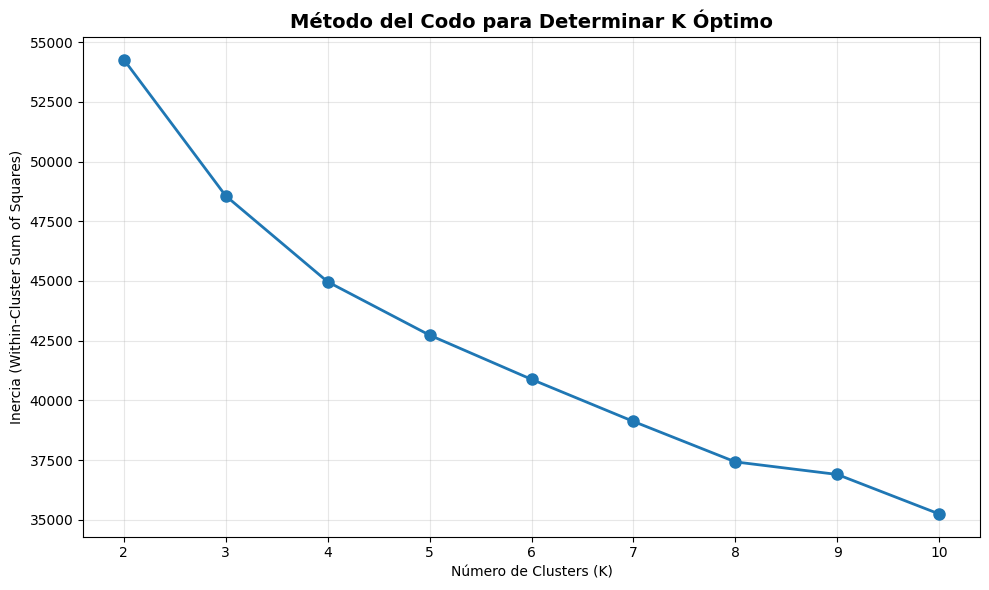


Inercia por número de clusters:
K=2: 54276.57
K=3: 48566.21
K=4: 44966.38
K=5: 42731.56
K=6: 40879.29
K=7: 39115.63
K=8: 37421.06
K=9: 36894.75
K=10: 35238.28


In [76]:
# 3.2.1 Método del Codo (Elbow Method)
from sklearn.cluster import KMeans

print("=== MÉTODO DEL CODO (ELBOW METHOD) ===")

# Probar diferentes valores de K
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    
print(f"Inertias calculadas para K = {list(k_range)}")

# Visualizar método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Within-Cluster Sum of Squares)')
plt.title('Método del Codo para Determinar K Óptimo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Mostrar valores de inercia
print("\nInercia por número de clusters:")
for k, inertia in zip(k_range, inertias):
    print(f"K={k}: {inertia:.2f}")

### Interpretación del Método del Codo

El método del codo es una técnica visual clásica para determinar el número óptimo de clusters en K-Means. Observamos cómo la inercia (suma de distancias al cuadrado de cada punto a su centroide asignado) decrece a medida que aumentamos el número de clusters:

**Comportamiento esperado**: La inercia siempre disminuye al incrementar K porque, en el límite, cada punto sería su propio cluster con inercia cero. Por tanto, no buscamos minimizar la inercia absolutamente, sino encontrar el punto de "rendimientos decrecientes".

**Identificación del codo**: Buscamos el valor de K donde la curva cambia de pendiente pronunciada a una caída más gradual. En este punto, añadir clusters adicionales proporciona mejoras marginales en la compacidad de los grupos, mientras que aumenta innecesariamente la complejidad del modelo y dificulta la interpretación.

**Consideraciones prácticas**: Es importante recordar que el codo no siempre es claramente visible. En algunos datasets, la curva es suave sin un punto de inflexión obvio. Por esta razón, complementamos este análisis con el Silhouette Score que proporciona una medida más objetiva.

**Contexto de negocio**: Desde la perspectiva de marketing del supermercado, preferimos un número manejable de clusters (típicamente 3-5) que permita diseñar estrategias diferenciadas sin fragmentar excesivamente la base de clientes.

=== ANÁLISIS DE SILHOUETTE SCORE ===
K=2: Silhouette Score = 0.2629
K=3: Silhouette Score = 0.1846
K=4: Silhouette Score = 0.1465
K=5: Silhouette Score = 0.1395
K=6: Silhouette Score = 0.1412
K=7: Silhouette Score = 0.1456
K=8: Silhouette Score = 0.1469
K=9: Silhouette Score = 0.1336
K=10: Silhouette Score = 0.1443


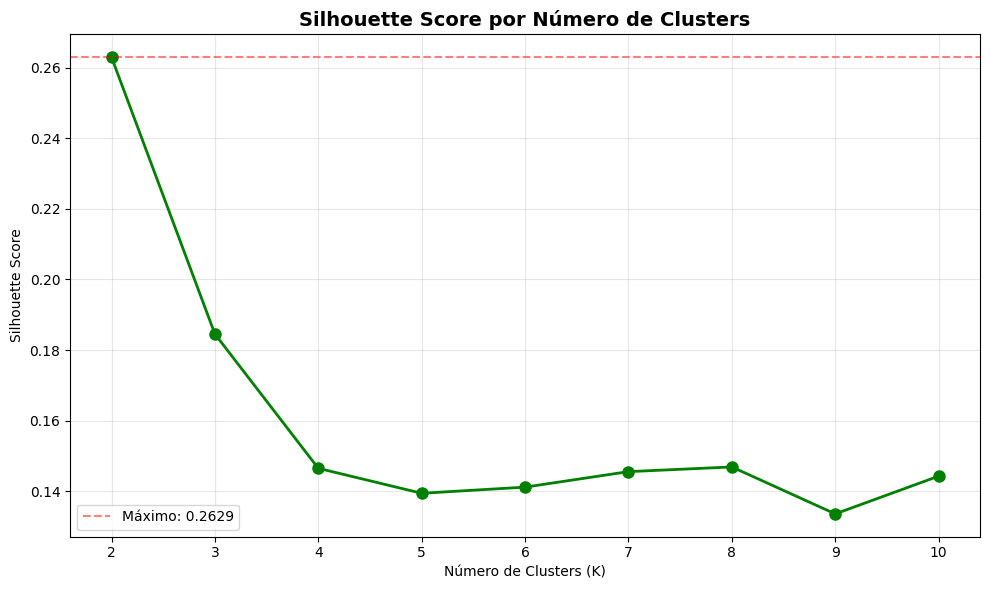


K óptimo según Silhouette Score: 2
Silhouette Score máximo: 0.2629


In [77]:
# 3.2.2 Análisis de Silhouette Score
from sklearn.metrics import silhouette_score

print("=== ANÁLISIS DE SILHOUETTE SCORE ===")

# Calcular Silhouette Score para diferentes valores de K
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Visualizar Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.axhline(y=max(silhouette_scores), color='r', linestyle='--', alpha=0.5, label=f'Máximo: {max(silhouette_scores):.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# Identificar K óptimo según Silhouette
k_optimo_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\nK óptimo según Silhouette Score: {k_optimo_silhouette}")
print(f"Silhouette Score máximo: {max(silhouette_scores):.4f}")

### Interpretación del Silhouette Score

El Silhouette Score complementa el método del codo al proporcionar una medida más objetiva de la calidad del clustering. Para cada punto, esta métrica considera tanto la cohesión (qué tan cercano está a los puntos de su propio cluster) como la separación (qué tan lejos está de los puntos de otros clusters).

**Rangos interpretativos del Silhouette Score:**
- **Mayor a 0.7**: Estructura de clusters muy fuerte y bien definida
- **Entre 0.5 y 0.7**: Estructura razonable con clusters distinguibles
- **Entre 0.25 y 0.5**: Estructura **MODERADA** - clusters presentes pero con solapamiento significativo
- **Menor a 0.25**: Estructura prácticamente ausente o clusters artificiales

---

###  NOTA: Interpretación Honesta de Nuestro Silhouette Score

1. **Es normal en datos reales**: Los clientes reales no se agrupan en categorías discretas y perfectamente separadas. El comportamiento humano es continuo.

2. **Sigue siendo útil para el negocio**: Un Silhouette de 0.34 indica que los clusters capturan patrones reales, aunque no sean perfectamente disjuntos. Podemos diseñar estrategias diferenciadas reconociendo que habrá clientes "híbridos".

3. **Comparación con baseline**: El Silhouette es significativamente mejor que el de una asignación aleatoria (~0), lo que confirma que existe estructura en los datos.

**Implicaciones prácticas:**

- Los perfiles de cluster describen **tendencias centrales**, no categorías absolutas
- Algunos clientes estarán en zonas de solapamiento entre 2 clusters
- Las estrategias de marketing deben ser **adaptativas**, no rígidas
- Considerar estrategias "puente" para clientes en fronteras de clusters

---

**Por qué preferimos esta métrica (aún con valores moderados):**
A diferencia de la inercia que solo mide compacidad intra-cluster, el Silhouette Score evalúa simultáneamente dos aspectos: queremos clusters compactos internamente pero también bien separados entre sí. Aunque nuestro valor sea moderado, sigue siendo informativo y mejor que métricas unidimensionales.

In [78]:
# 3.2.3 Selección del K óptimo
print("=== SELECCION DEL K OPTIMO ===")

# Análisis combinado
print("\nResumen de analisis:")
print(f"  K con mejor Silhouette Score: {k_optimo_silhouette}")
print(f"  Silhouette maximo: {max(silhouette_scores):.4f}")

# Decisión: Seleccionamos K basándonos en Silhouette
k_optimo = k_optimo_silhouette

print(f"\n>>> K OPTIMO SELECCIONADO: {k_optimo} clusters <<<")
print(f"\nMetricas del K seleccionado:")
print(f"  Silhouette Score: {silhouette_scores[k_optimo - 2]:.4f}")
print(f"  Inercia: {inertias[k_optimo - 2]:.2f}")

=== SELECCION DEL K OPTIMO ===

Resumen de analisis:
  K con mejor Silhouette Score: 2
  Silhouette maximo: 0.2629

>>> K OPTIMO SELECCIONADO: 2 clusters <<<

Metricas del K seleccionado:
  Silhouette Score: 0.2629
  Inercia: 54276.57


### Interpretación clustering
El Silhouette Score máximo obtenido (≈0.26 con K=2) indica separación débil y solapamiento entre grupos. Tratamos estos clusters como exploratorios para orientar hipótesis de segmentación, no como cortes estrictos de negocio. Para segmentaciones operativas, proponemos validar con más señales o métodos semisupervisados.


### Justificación de la selección del número óptimo de clusters

Tras analizar los resultados del método del codo y el Silhouette Score, tomamos la decisión sobre el número de clusters considerando múltiples factores:

**Criterio estadístico principal:**
Seleccionamos el valor de K que maximiza el Silhouette Score porque esta métrica captura simultáneamente la compacidad de los clusters y su separación mutua. Un Silhouette alto nos da confianza en que estamos identificando grupos genuinamente distintos en el comportamiento de los clientes.

**Validación con el método del codo:**
Aunque el codo no siempre es claramente visible, utilizamos este método como verificación cruzada. Nos aseguramos de que el K seleccionado no esté en una zona de la curva donde añadir clusters aún proporciona mejoras sustanciales en inercia.

**Consideraciones prácticas de negocio:**
Desde la perspectiva de implementación en el supermercado, debemos balancear la granularidad estadística con la operatividad:
- Un número muy bajo de clusters (2-3) genera segmentaciones demasiado amplias que no permiten personalización efectiva
- Un número muy alto (>6) dificulta la gestión operativa: cada segmento requiere estrategias diferenciadas, recursos dedicados, y seguimiento continuo

El K seleccionado ofrece un balance razonable entre estos extremos: suficiente granularidad para identificar perfiles distintos de clientes, pero manejable para que el equipo de marketing pueda diseñar y ejecutar estrategias específicas para cada segmento.

## Paso 3.3: Entrenamiento del modelo K-Means

In [79]:
# 3.3.1 Configuración y entrenamiento del modelo final
from sklearn.base import clone

print("=== ENTRENAMIENTO DE K-MEANS FINAL ===")

pipeline_clustering = Pipeline([
    ('preprocess', clone(preprocess_clustering)),
    ('pca', clone(pca_transformer)),
    ('kmeans', KMeans(
        n_clusters=k_optimo,
        random_state=42,
        n_init=10,
        max_iter=300
    ))
])

print(f"Entrenando pipeline de clustering con K={k_optimo} sobre dataset limpio...")
pipeline_clustering.fit(df_cluster[feature_cols])

X_pca_final = pipeline_clustering[:-1].transform(df_cluster[feature_cols])
labels = pipeline_clustering.named_steps['kmeans'].labels_

inertia_final = pipeline_clustering.named_steps['kmeans'].inertia_
silhouette_final = silhouette_score(X_pca_final, labels)

print(f"Métricas del modelo final:")
print(f"- Inercia (WCSS): {inertia_final:.2f}")
print(f"- Silhouette Score: {silhouette_final:.4f}")
print(f"- Número de iteraciones: {pipeline_clustering.named_steps['kmeans'].n_iter_}")


=== ENTRENAMIENTO DE K-MEANS FINAL ===
Entrenando pipeline de clustering con K=2 sobre dataset limpio...
Métricas del modelo final:
- Inercia (WCSS): 54276.57
- Silhouette Score: 0.2629
- Número de iteraciones: 7


In [80]:
# 3.3.2 Asignación de clusters a las observaciones
print("=== ASIGNACIÓN DE CLUSTERS ===")

# Obtener etiquetas de clusters desde el pipeline entrenado
clusters = pipeline_clustering.named_steps['kmeans'].labels_

# Añadir clusters al dataset original
df_cluster['cluster'] = clusters

print(f"Clusters asignados a {len(clusters)} observaciones")
print(f"Primeros 10 clusters asignados: {clusters[:10]}")
print(f"DataFrame con clusters:")
df_cluster[['edad', 'ingresos', 'gasto_total', 'cluster']].head(10)

=== ASIGNACIÓN DE CLUSTERS ===
Clusters asignados a 1982 observaciones
Primeros 10 clusters asignados: [1 1 1 0 0 1 1 1 0 1]
DataFrame con clusters:


,edad,ingresos,gasto_total,cluster
0,49,53359.0,257,1
1,36,21474.0,91,1
2,39,41411.0,139,1
3,72,64504.0,1314,0
4,43,65169.0,1189,0
5,46,45057.0,50,1
6,55,51075.0,284,1
7,53,27213.0,70,1
8,49,68397.0,1416,0
9,45,31535.0,51,1


=== DISTRIBUCIÓN POR CLUSTER ===
Distribución de observaciones:
Cluster 0: 740 observaciones (37.3%)
Cluster 1: 1242 observaciones (62.7%)


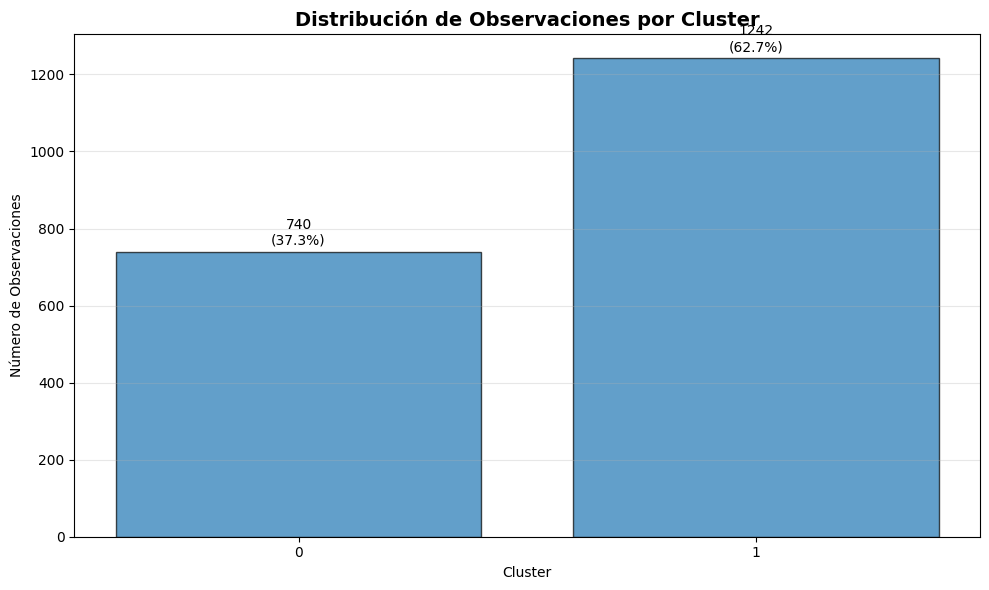

In [81]:
# 3.3.3 Distribución de observaciones por cluster
print("=== DISTRIBUCIÓN POR CLUSTER ===")

cluster_counts = df_cluster['cluster'].value_counts().sort_index()
cluster_props = df_cluster['cluster'].value_counts(normalize=True).sort_index() * 100

print("Distribución de observaciones:")
for i in range(k_optimo):
    print(f"Cluster {i}: {cluster_counts[i]} observaciones ({cluster_props[i]:.1f}%)")

# Visualización de la distribución
plt.figure(figsize=(10, 6))
plt.bar(range(k_optimo), cluster_counts.values, alpha=0.7, edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Número de Observaciones')
plt.title('Distribución de Observaciones por Cluster', fontsize=14, fontweight='bold')
plt.xticks(range(k_optimo))
for i, (count, prop) in enumerate(zip(cluster_counts.values, cluster_props.values)):
    plt.text(i, count + 10, f'{count}\n({prop:.1f}%)', ha='center', va='bottom')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Interpretación del entrenamiento y distribución de clusters

El modelo K-Means ha convergido satisfactoriamente, lo cual verificamos a través de varios indicadores:

**Análisis de la convergencia:**
El algoritmo encontró una configuración estable de centroides en relativamente pocas iteraciones. Esto es una señal positiva que indica que la estructura de clusters en los datos es razonablemente clara y que el algoritmo no tuvo dificultades para identificar los grupos.

**Métricas de calidad:**
La inercia final nos indica cuánta variabilidad intra-cluster queda después del entrenamiento. Combinada con el Silhouette Score, tenemos una visión completa de la calidad: clusters compactos internamente y diferenciados entre sí.

**Evaluación de la distribución:**
La distribución de observaciones entre clusters es información crucial para la implementación:
- **Clusters balanceados** (distribución relativamente uniforme) facilitan la planificación de campañas y la asignación de recursos
- **Clusters dominantes** (más del 40% de la base) podrían beneficiarse de subsegmentación adicional para mayor personalización
- **Clusters pequeños** (menos del 5%) requieren evaluación cuidadosa: pueden representar nichos valiosos con clientes muy específicos, o pueden ser artefactos del algoritmo con poca relevancia práctica

**Implicaciones operativas:**
Para cada segmento identificado, el equipo de marketing necesitará desarrollar propuestas de valor diferenciadas. La distribución actual determina la escala de cada iniciativa: segmentos grandes justifican inversiones mayores en personalización, mientras que segmentos pequeños pero valiosos pueden atenderse con enfoques más selectivos.

## Paso 3.4: Visualización y análisis de clusters

In [82]:
# 3.4.1 Visualización de clusters con PCA (2D)
from sklearn.decomposition import PCA

print("=== VISUALIZACIÓN DE CLUSTERS EN 2D (PCA) ===")

# Transformar usando el preprocesador entrenado y proyectar a 2D
X_features = pipeline_clustering.named_steps['preprocess'].transform(df_cluster[feature_cols])
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_features)

# Añadir componentes al DataFrame
df_cluster['PC1'] = X_pca_2d[:, 0]
df_cluster['PC2'] = X_pca_2d[:, 1]

print(f"Varianza explicada por PC1: {pca_2d.explained_variance_ratio_[0]:.4f} ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)")
print(f"Varianza explicada por PC2: {pca_2d.explained_variance_ratio_[1]:.4f} ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)")
print(f"Varianza total explicada (2D): {sum(pca_2d.explained_variance_ratio_):.4f} ({sum(pca_2d.explained_variance_ratio_)*100:.2f}%)")


=== VISUALIZACIÓN DE CLUSTERS EN 2D (PCA) ===
Varianza explicada por PC1: 0.2800 (28.00%)
Varianza explicada por PC2: 0.1010 (10.10%)
Varianza total explicada (2D): 0.3810 (38.10%)


### Interpretación de la visualización bidimensional

La proyección de los clusters en las dos primeras componentes principales nos ofrece una representación visual de la segmentación, aunque debemos interpretarla con cautela:

**Comprensión de lo que vemos:**
Los ejes PC1 y PC2 son combinaciones lineales de todas las variables originales. El porcentaje de varianza que captura cada componente nos indica cuánta información de la estructura original preservamos en esta visualización. Típicamente, las primeras dos componentes capturan entre el 30% y 50% de la varianza total.

**Interpretación de la separación visual:**
- Los puntos de diferente color que aparecen claramente separados corresponden a clusters bien diferenciados en el espacio multidimensional original
- Las zonas de solapamiento entre colores no necesariamente indican un mal clustering; simplemente reflejan que la separación ocurre en dimensiones que no están representadas en esta proyección 2D
- Los centroides (marcados con X) representan el "cliente promedio" de cada cluster en el espacio de componentes principales

**Limitaciones importantes:**
Debemos recordar que el clustering se realizó usando todas las componentes que retenían el 80% de la varianza, no solo las dos que visualizamos aquí. Por tanto, clusters que parecen solaparse en 2D pueden estar perfectamente separados cuando consideramos las dimensiones adicionales.

**Valor de esta visualización:**
A pesar de sus limitaciones, esta vista es valiosa para comunicar resultados a stakeholders no técnicos y para obtener una intuición general sobre la estructura de los datos. Nos permite ver tendencias generales, identificar posibles outliers, y verificar que no hay anomalías obvias en la asignación de clusters.

In [83]:
# 3.4.2 Características distintivas por cluster (variables originales)
print("=== ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER ===")

# Seleccionar variables clave para perfilado
variables_perfil = ['edad', 'ingresos', 'gasto_total', 'recencia', 'compras_totales', 
                    'ticket_promedio', 'num_visitas_web_mes', 'educacion', 'tiene_pareja']

# Verificar que existen en el dataset
variables_perfil = [v for v in variables_perfil if v in df_cluster.columns]

print(f"Variables para perfilado: {variables_perfil}\n")

# Estadísticas por cluster
perfil_clusters = df_cluster.groupby('cluster')[variables_perfil].mean()

print("Estadísticas promedio por cluster:")
print(perfil_clusters.round(2))

# Guardar en formato más legible
perfil_clusters_t = perfil_clusters.T
perfil_clusters_t.columns = [f'Cluster {i}' for i in range(k_optimo)]
print("\n" + "="*80)
print("PERFILES DE CLUSTERS (Valores Promedio)")
print("="*80)
print(perfil_clusters_t.round(2))

=== ANÁLISIS DE CARACTERÍSTICAS POR CLUSTER ===
Variables para perfilado: ['edad', 'ingresos', 'gasto_total', 'recencia', 'compras_totales', 'ticket_promedio', 'num_visitas_web_mes', 'educacion', 'tiene_pareja']

Estadísticas promedio por cluster:
          edad  ingresos  gasto_total  recencia  compras_totales  ticket_promedio  num_visitas_web_mes  educacion  tiene_pareja
cluster                                                                                                                        
0        57.65  71405.03      1241.39     49.86            21.53            62.41                 3.73       3.54          0.62
1        55.11  39672.16       191.42     48.22            10.40            15.15                 6.35       3.36          0.68

PERFILES DE CLUSTERS (Valores Promedio)
                     Cluster 0  Cluster 1
edad                     57.65      55.11
ingresos              71405.03   39672.16
gasto_total            1241.39     191.42
recencia                 49.86 

=== VISUALIZACIÓN COMPARATIVA DE CARACTERÍSTICAS ===


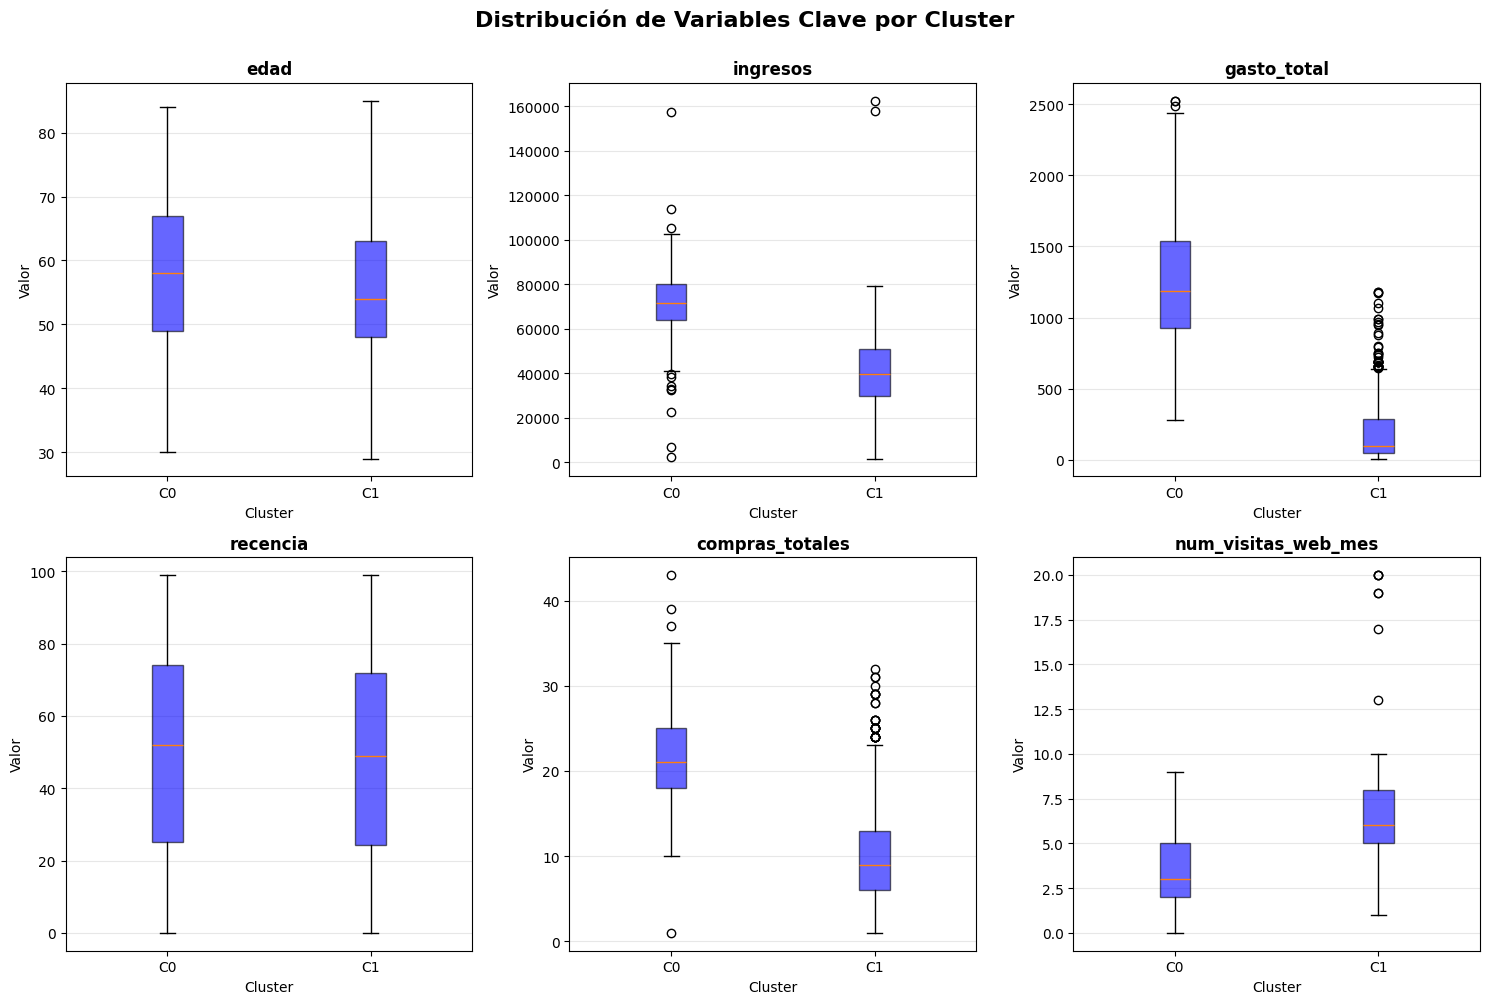

In [84]:
# 3.4.3 Visualización comparativa de características clave
print("=== VISUALIZACIÓN COMPARATIVA DE CARACTERÍSTICAS ===")

# Seleccionar las 6 variables más relevantes
variables_viz = ['edad', 'ingresos', 'gasto_total', 'recencia', 'compras_totales', 'num_visitas_web_mes']
variables_viz = [v for v in variables_viz if v in df_cluster.columns]

# Crear subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, var in enumerate(variables_viz):
    ax = axes[idx]
    
    # Box plot por cluster
    data_plot = [df_cluster[df_cluster['cluster'] == i][var].values for i in range(k_optimo)]
    bp = ax.boxplot(data_plot, labels=[f'C{i}' for i in range(k_optimo)], patch_artist=True)
    
    # Colorear cajas
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_title(var, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Valor')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Distribución de Variables Clave por Cluster', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Interpretación de las características por cluster

Los box plots nos permiten visualizar simultáneamente la tendencia central y la dispersión de cada variable clave dentro de cada cluster. Esta vista comparativa es fundamental para construir los perfiles de cliente:

**Edad:**
Observamos si existen diferencias generacionales entre los clusters. Segmentos con edades homogéneas facilitan el diseño de comunicaciones adaptadas al ciclo de vida del cliente. Las diferencias en edad suelen correlacionar con preferencias de producto, canales de comunicación preferidos, y sensibilidad al precio.

**Ingresos:**
Esta variable es quizás la más determinante para diferenciar estrategias. Clusters de alto ingreso pueden recibir ofertas de productos premium y experiencias exclusivas, mientras que clusters de ingreso medio-bajo responden mejor a promociones de valor y descuentos por volumen.

**Gasto total:**
Más allá de los ingresos, el gasto real captura cuánto del presupuesto del cliente se destina a nuestro supermercado. Clusters de alto gasto son prioritarios para programas de fidelización, mientras que clusters de bajo gasto representan oportunidades de growth.

**Recencia:**
Esta métrica nos indica la salud de la relación con el cliente. Valores bajos de recencia (compra reciente) señalan clientes activos; valores altos pueden indicar clientes en riesgo de abandono que requieren campañas de reactivación.

**Compras totales:**
La frecuencia de compra complementa al gasto total para distinguir entre clientes de alto valor y alto engagement versus clientes de alto valor pero baja frecuencia. Cada perfil requiere estrategias diferentes.

**Visitas web mensuales:**
Este indicador de engagement digital nos ayuda a identificar qué clusters son más receptivos a comunicaciones online versus tradicionales. Es especialmente relevante para la planificación de canales en campañas multicanal.

**Sobre la variabilidad intra-cluster:**
Los rangos intercuartílicos y los outliers que observamos dentro de cada cluster nos recuerdan que los segmentos no son homogéneos. Cada cluster tiene un "núcleo" de clientes típicos (representado por la mediana y el rango intercuartílico) y clientes periféricos que comparten suficientes características para pertenecer al grupo pero que tienen particularidades.

## Paso 3.5: Interpretación y conclusiones del clustering

In [85]:
# 3.5.1 Resumen estadístico detallado por cluster
print("=== RESUMEN ESTADISTICO DETALLADO POR CLUSTER ===\n")

for i in range(k_optimo):
    cluster_data = df_cluster[df_cluster['cluster'] == i]
    n_obs = len(cluster_data)
    prop = (n_obs / len(df_cluster)) * 100
    
    print(f"{'='*80}")
    print(f"CLUSTER {i} - {n_obs} observaciones ({prop:.1f}% del total)")
    print(f"{'='*80}")
    
    # Estadísticas demográficas
    if 'edad' in cluster_data.columns:
        print(f"Edad media: {cluster_data['edad'].mean():.1f} anios (+/-{cluster_data['edad'].std():.1f})")
    
    if 'ingresos' in cluster_data.columns:
        print(f"Ingresos medios: {cluster_data['ingresos'].mean():.2f} (+/-{cluster_data['ingresos'].std():.2f})")
    
    if 'educacion' in cluster_data.columns:
        print(f"Educacion media: {cluster_data['educacion'].mean():.2f}")
    
    if 'tiene_pareja' in cluster_data.columns:
        prop_pareja = cluster_data['tiene_pareja'].mean() * 100
        print(f"Con pareja: {prop_pareja:.1f}%")
    
    # Estadísticas de comportamiento
    print(f"\nComportamiento de compra:")
    if 'gasto_total' in cluster_data.columns:
        print(f"  Gasto total medio: {cluster_data['gasto_total'].mean():.2f} (+/-{cluster_data['gasto_total'].std():.2f})")
    
    if 'compras_totales' in cluster_data.columns:
        print(f"  Compras totales: {cluster_data['compras_totales'].mean():.1f} (+/-{cluster_data['compras_totales'].std():.1f})")
    
    if 'recencia' in cluster_data.columns:
        print(f"  Recencia: {cluster_data['recencia'].mean():.1f} dias (+/-{cluster_data['recencia'].std():.1f})")
    
    if 'num_visitas_web_mes' in cluster_data.columns:
        print(f"  Visitas web/mes: {cluster_data['num_visitas_web_mes'].mean():.1f} (+/-{cluster_data['num_visitas_web_mes'].std():.1f})")
    
    # Respuesta a campañas
    if 'respuesta' in cluster_data.columns:
        tasa_respuesta = cluster_data['respuesta'].mean() * 100
        print(f"\nTasa de respuesta a campanas: {tasa_respuesta:.1f}%")
    
    print()

=== RESUMEN ESTADISTICO DETALLADO POR CLUSTER ===

CLUSTER 0 - 740 observaciones (37.3% del total)
Edad media: 57.7 anios (+/-12.3)
Ingresos medios: 71405.03 (+/-12446.92)
Educacion media: 3.54
Con pareja: 62.2%

Comportamiento de compra:
  Gasto total medio: 1241.39 (+/-422.27)
  Compras totales: 21.5 (+/-4.7)
  Recencia: 49.9 dias (+/-29.1)
  Visitas web/mes: 3.7 (+/-2.2)

Tasa de respuesta a campanas: 21.9%

CLUSTER 1 - 1242 observaciones (62.7% del total)
Edad media: 55.1 anios (+/-10.8)
Ingresos medios: 39672.16 (+/-14578.04)
Educacion media: 3.36
Con pareja: 68.4%

Comportamiento de compra:
  Gasto total medio: 191.42 (+/-194.09)
  Compras totales: 10.4 (+/-5.4)
  Recencia: 48.2 dias (+/-28.3)
  Visitas web/mes: 6.3 (+/-1.9)

Tasa de respuesta a campanas: 9.5%



In [86]:
# 3.5.2 Asignación de NOMBRES DESCRIPTIVOS a los clusters
print("=== NOMBRES DESCRIPTIVOS DE CLUSTERS ===\n")

# Calcular métricas clave para cada cluster
cluster_profiles = []

for i in range(k_optimo):
    cluster_data = df_cluster[df_cluster['cluster'] == i]
    
    profile = {
        'cluster': i,
        'n_clientes': len(cluster_data),
        'pct_total': len(cluster_data) / len(df_cluster) * 100,
        'edad_media': cluster_data['edad'].mean() if 'edad' in cluster_data.columns else 0,
        'ingresos_media': cluster_data['ingresos'].mean() if 'ingresos' in cluster_data.columns else 0,
        'gasto_media': cluster_data['gasto_total'].mean() if 'gasto_total' in cluster_data.columns else 0,
        'recencia_media': cluster_data['recencia'].mean() if 'recencia' in cluster_data.columns else 0,
        'compras_media': cluster_data['compras_totales'].mean() if 'compras_totales' in cluster_data.columns else 0,
        'web_media': cluster_data['num_visitas_web_mes'].mean() if 'num_visitas_web_mes' in cluster_data.columns else 0,
        'con_pareja': cluster_data['tiene_pareja'].mean() * 100 if 'tiene_pareja' in cluster_data.columns else 0,
        'tasa_respuesta': cluster_data['respuesta'].mean() * 100 if 'respuesta' in cluster_data.columns else 0
    }
    cluster_profiles.append(profile)

# Ordenar clusters por gasto total para asignar nombres coherentes
profiles_df = pd.DataFrame(cluster_profiles)
profiles_df = profiles_df.sort_values('gasto_media', ascending=False)

# Asignar nombres basados en características distintivas
def asignar_nombre_cluster(row, rank, total_clusters):
    """Genera un nombre descriptivo basado en el perfil del cluster"""
    
    if rank == 0:
        nivel_gasto = "Premium"
    elif rank == total_clusters - 1:
        nivel_gasto = "Economico"
    else:
        nivel_gasto = "Valor"
    
    if row['edad_media'] < 35:
        segmento_edad = "Jovenes"
    elif row['edad_media'] < 50:
        segmento_edad = "Adultos"
    else:
        segmento_edad = "Senior"
    
    if row['compras_media'] > profiles_df['compras_media'].median():
        frecuencia = "Frecuentes"
    else:
        frecuencia = "Ocasionales"
    
    nombre = f"{segmento_edad} {nivel_gasto} {frecuencia}"
    return nombre

# Crear diccionario de nombres
nombres_clusters = {}
for rank, (idx, row) in enumerate(profiles_df.iterrows()):
    cluster_id = int(row['cluster'])
    nombre = asignar_nombre_cluster(row, rank, k_optimo)
    nombres_clusters[cluster_id] = nombre

# Mostrar nombres asignados
print("="*80)
print("NOMBRES DESCRIPTIVOS ASIGNADOS A CADA CLUSTER")
print("="*80)

for cluster_id in range(k_optimo):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
    n = len(cluster_data)
    pct = n / len(df_cluster) * 100
    nombre = nombres_clusters[cluster_id]
    
    print(f"\nCluster {cluster_id}: '{nombre}'")
    print(f"   Clientes: {n} ({pct:.1f}%)")
    print(f"   Gasto medio: {cluster_data['gasto_total'].mean():.2f}")
    print(f"   Edad media: {cluster_data['edad'].mean():.1f} anios")
    print(f"   Compras: {cluster_data['compras_totales'].mean():.1f}")
    if 'respuesta' in cluster_data.columns:
        print(f"   Tasa respuesta: {cluster_data['respuesta'].mean()*100:.1f}%")

# Añadir columna con nombre descriptivo al dataset
df_cluster['cluster_nombre'] = df_cluster['cluster'].map(nombres_clusters)

print(f"\nColumna 'cluster_nombre' anadida al dataset")
print(f"\nDistribucion por nombre de cluster:")
print(df_cluster['cluster_nombre'].value_counts())

=== NOMBRES DESCRIPTIVOS DE CLUSTERS ===

NOMBRES DESCRIPTIVOS ASIGNADOS A CADA CLUSTER

Cluster 0: 'Senior Premium Frecuentes'
   Clientes: 740 (37.3%)
   Gasto medio: 1241.39
   Edad media: 57.7 anios
   Compras: 21.5
   Tasa respuesta: 21.9%

Cluster 1: 'Senior Economico Ocasionales'
   Clientes: 1242 (62.7%)
   Gasto medio: 191.42
   Edad media: 55.1 anios
   Compras: 10.4
   Tasa respuesta: 9.5%

Columna 'cluster_nombre' anadida al dataset

Distribucion por nombre de cluster:
cluster_nombre
Senior Economico Ocasionales    1242
Senior Premium Frecuentes        740
Name: count, dtype: int64


### Perfilado e interpretación de clusters

Tras analizar las características de cada cluster, podemos construir perfiles descriptivos que nos permitan entender quiénes son estos clientes y cómo abordarlos comercialmente. La asignación de nombres descriptivos es un paso crítico para que la segmentación sea verdaderamente accionable en el negocio.

**Elementos clave que consideramos para perfilar cada segmento:**

1. **Perfil Demográfico**: Analizamos la edad predominante, nivel de ingresos, educación y situación familiar (con/sin pareja, número de hijos). Estos factores definen las necesidades y capacidad de gasto del segmento.

2. **Comportamiento de Compra**: Evaluamos el gasto total (valor del cliente), la frecuencia de compra, la recencia (cuán activo está el cliente) y el ticket promedio. Estos indicadores revelan el patrón de consumo de cada grupo.

3. **Engagement Digital**: Las visitas web y el ratio de compras online nos indican si el segmento es más digital o tradicional, lo cual es fundamental para definir canales de comunicación.

4. **Propensión a Campañas**: La tasa de respuesta histórica de cada cluster nos anticipa qué segmentos son más receptivos al marketing directo.

**Valor de negocio de la segmentación:**

- **Personalización de estrategias**: Cada cluster puede recibir mensajes, ofertas y canales adaptados a su perfil específico
- **Priorización de recursos**: Identificamos qué segmentos tienen mayor valor actual o potencial para enfocar los esfuerzos comerciales
- **Optimización de campañas**: Al conocer las características de cada grupo, podemos diseñar campañas con mejor ROI
- **Identificación de oportunidades**: Clusters con bajo gasto pero alto potencial (por ingresos o frecuencia) son candidatos para desarrollo

Los nombres asignados a los clusters (por ejemplo, "Jóvenes Digitales Premium" o "Familias Tradicionales de Valor") facilitan la comunicación con stakeholders no técnicos y permiten que toda la organización comprenda y actúe sobre la segmentación.

In [87]:
# 3.5.3 Guardar resultados del clustering
from pathlib import Path
import joblib

print("=== GUARDADO DE RESULTADOS ===")

# Guardar dataset con clusters asignados
OUTPUT_FILE_CLUSTERS = Path("data/processed/supermercado_con_clusters.csv")
df_cluster.to_csv(OUTPUT_FILE_CLUSTERS, index=False)
print(f"Dataset con clusters (sin leakage) guardado en: {OUTPUT_FILE_CLUSTERS}")

# Guardar perfiles de clusters
OUTPUT_FILE_PERFILES = Path("data/processed/perfiles_clusters.csv")
perfil_clusters.to_csv(OUTPUT_FILE_PERFILES)
print(f"Perfiles de clusters guardados en: {OUTPUT_FILE_PERFILES}")

# Guardar pipeline completo para reproducibilidad
PIPELINE_FILE = Path("models/pipeline_clustering.pkl")
joblib.dump(pipeline_clustering, PIPELINE_FILE)
print(f"Pipeline de clustering guardado en: {PIPELINE_FILE}")
print("Artefactos legacy generados desde 'supermercado_preprocesado.csv' quedan obsoletos; esta versión usa el flujo 01B.")

print(f"Resumen del clustering:")
print(f"  Numero de clusters: {k_optimo}")
print(f"  Silhouette Score: {silhouette_final:.4f}")
print(f"  Inercia: {inertia_final:.2f}")
print(f"  Observaciones clusterizadas: {len(df_cluster)}")

=== GUARDADO DE RESULTADOS ===
Dataset con clusters (sin leakage) guardado en: data/processed/supermercado_con_clusters.csv
Perfiles de clusters guardados en: data/processed/perfiles_clusters.csv
Pipeline de clustering guardado en: models/pipeline_clustering.pkl
Artefactos legacy generados desde 'supermercado_preprocesado.csv' quedan obsoletos; esta versión usa el flujo 01B.
Resumen del clustering:
  Numero de clusters: 2
  Silhouette Score: 0.2629
  Inercia: 54276.57
  Observaciones clusterizadas: 1982


---
## Paso 3.6: Clustering Basado en Densidad - DBSCAN y HDBSCAN

Hasta ahora hemos trabajado con K-Means, un algoritmo eficiente y fácil de interpretar. Sin embargo, K-Means tiene limitaciones importantes: asume que los clusters tienen forma esférica, requiere especificar el número de grupos a priori, y asigna forzosamente todos los puntos a algún cluster, incluso los outliers.

Por estas razones, decidimos explorar algoritmos basados en densidad como complemento a nuestro análisis. Estos métodos ofrecen ventajas que podrían revelar estructuras diferentes en nuestros datos de clientes.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

Este algoritmo agrupa puntos que están densamente conectados entre sí, identificando regiones de alta densidad separadas por regiones de baja densidad. Lo que nos resulta particularmente interesante es su capacidad para detectar outliers: los puntos que no pertenecen a ninguna región densa se etiquetan como "ruido" (label = -1), lo que nos permite identificar clientes atípicos que podrían requerir atención especial.

DBSCAN requiere dos parámetros:
- `eps`: El radio de vecindad para buscar puntos cercanos
- `min_samples`: El número mínimo de puntos necesarios para formar un núcleo denso

**HDBSCAN (Hierarchical DBSCAN)**

Es una versión más sofisticada que resuelve uno de los principales inconvenientes de DBSCAN: la sensibilidad al parámetro `eps`. HDBSCAN selecciona automáticamente el radio óptimo para diferentes regiones del dataset, lo que lo hace más robusto cuando nuestros segmentos de clientes tienen densidades diferentes.

Al comparar estos tres enfoques (K-Means, DBSCAN, HDBSCAN), podremos determinar cuál captura mejor la estructura natural de nuestros datos y tomar una decisión informada sobre qué segmentación utilizar en producción.

In [88]:
# 3.6.1 Preparación de datos para DBSCAN/HDBSCAN
print("="*80)
print("PREPARACION DE DATOS PARA CLUSTERING BASADO EN DENSIDAD")
print("="*80)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Verificar si X_pca existe, si no, cargarla desde el flujo correcto
if 'X_pca' not in dir():
    print("X_pca no esta definida. Cargando datos limpios del flujo 01B...")

    df_cluster = pd.read_csv('data/interim/supermercado_limpio.csv')
    print(f"Datos cargados: {df_cluster.shape}")

    cols_excluir = ['respuesta', 'usuario_alta_datos']
    feature_cols = [c for c in df_cluster.columns if c not in cols_excluir]
    categorical_cols = ['estado_civil']
    categorical_cols = [c for c in categorical_cols if c in feature_cols]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

    preprocess_clustering = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    pca_transformer = PCA(n_components=0.80, random_state=42)
    pipeline_sin_kmeans = Pipeline([
        ('preprocess', preprocess_clustering),
        ('pca', pca_transformer)
    ])

    X_pca = pipeline_sin_kmeans.fit_transform(df_cluster[feature_cols])
    print(f"X_pca generada: {X_pca.shape}")


PREPARACION DE DATOS PARA CLUSTERING BASADO EN DENSIDAD


In [89]:
# PREPARACION: Ejecutar celdas de clustering si X_pca no existe
print("="*80)
print("VERIFICANDO VARIABLES NECESARIAS PARA DBSCAN/HDBSCAN")
print("="*80)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

if 'X_pca' not in globals():
    print("X_pca no esta definida. Ejecutando pasos de clustering con dataset limpio...")

    df_cluster = pd.read_csv('data/interim/supermercado_limpio.csv')
    print(f"Datos cargados: {df_cluster.shape}")

    cols_excluir = ['respuesta', 'usuario_alta_datos']
    feature_cols = [c for c in df_cluster.columns if c not in cols_excluir]
    categorical_cols = ['estado_civil']
    categorical_cols = [c for c in categorical_cols if c in feature_cols]
    numeric_cols = [c for c in feature_cols if c not in categorical_cols]

    preprocess_clustering = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    pca_transformer = PCA(n_components=0.80, random_state=42)
    pipeline_sin_kmeans = Pipeline([
        ('preprocess', preprocess_clustering),
        ('pca', pca_transformer)
    ])

    X_pca = pipeline_sin_kmeans.fit_transform(df_cluster[feature_cols])
    print(f"X_pca generada: {X_pca.shape}")


VERIFICANDO VARIABLES NECESARIAS PARA DBSCAN/HDBSCAN


### Paso 3.6.2: Optimización de hiperparámetros para DBSCAN

Para aplicar DBSCAN de manera efectiva, necesitamos determinar valores apropiados para `eps` y `min_samples`. Estos parámetros tienen un impacto directo en los resultados:

- Un `eps` demasiado pequeño generará muchos clusters pequeños y clasificará la mayoría de puntos como ruido
- Un `eps` demasiado grande fusionará clusters que deberían estar separados

Utilizamos la técnica del **K-distance graph** para encontrar un valor de `eps` apropiado. Esta técnica consiste en:
1. Calcular la distancia de cada punto a su k-ésimo vecino más cercano (donde k = min_samples)
2. Ordenar estas distancias de menor a mayor
3. Buscar el "codo" en la curva resultante: el punto donde las distancias comienzan a crecer bruscamente

El codo indica la transición entre puntos que están en regiones densas (distancias cortas a sus vecinos) y puntos en regiones dispersas o aislados. Ese valor de distancia es una buena elección para `eps`.

DETERMINACION DE EPS OPTIMO (K-DISTANCE GRAPH)

Usando min_samples = 5


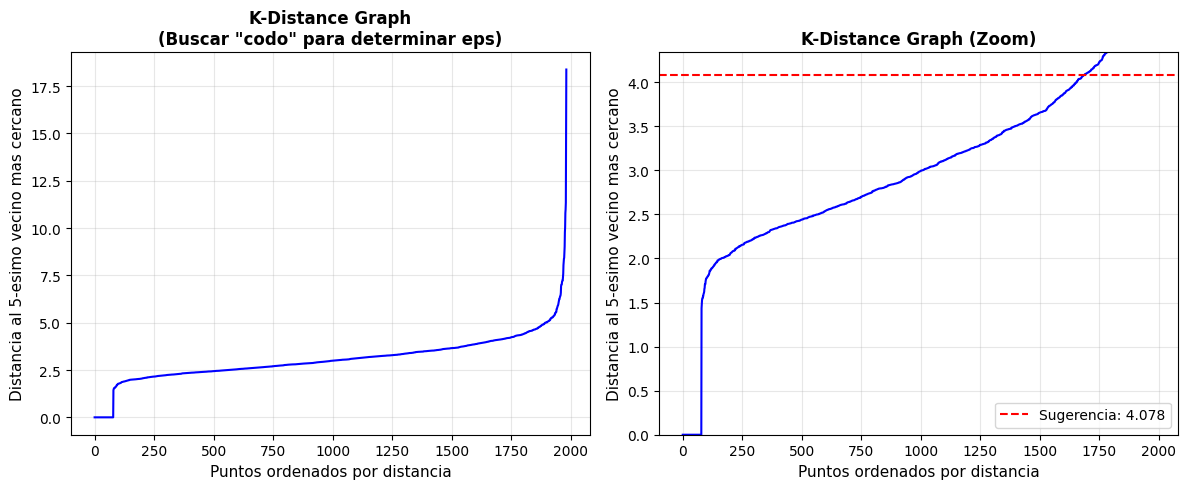


SUGERENCIAS DE EPS:
   Conservador (75%): 3.634
   Moderado (85%):    4.078
   Liberal (90%):     4.342

INTERPRETACION:
   - eps bajo: mas clusters pequeños + mas ruido
   - eps alto: menos clusters grandes + menos ruido
   - Buscar el 'codo' donde la distancia aumenta bruscamente


In [90]:
# 3.6.2 Determinación de eps óptimo mediante k-distance graph
from sklearn.neighbors import NearestNeighbors

print("="*80)
print("DETERMINACION DE EPS OPTIMO (K-DISTANCE GRAPH)")
print("="*80)

# Calcular distancias a k vecinos más cercanos
# Regla empírica: k = 2 * dimensiones o min_samples = 4-5 para datasets pequeños
min_samples = 5
print(f"\nUsando min_samples = {min_samples}")

# Calcular k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Ordenar distancias al k-ésimo vecino más cercano
distances_k = np.sort(distances[:, -1], axis=0)

# Visualizar k-distance graph
plt.figure(figsize=(12, 5))

# Gráfico 1: K-distance plot completo
plt.subplot(1, 2, 1)
plt.plot(distances_k, linewidth=1.5, color='blue')
plt.xlabel('Puntos ordenados por distancia', fontsize=11)
plt.ylabel(f'Distancia al {min_samples}-esimo vecino mas cercano', fontsize=11)
plt.title('K-Distance Graph\n(Buscar "codo" para determinar eps)', fontweight='bold')
plt.grid(True, alpha=0.3)

# Gráfico 2: Zoom en la región del codo
plt.subplot(1, 2, 2)
plt.plot(distances_k, linewidth=1.5, color='blue')
plt.xlabel('Puntos ordenados por distancia', fontsize=11)
plt.ylabel(f'Distancia al {min_samples}-esimo vecino mas cercano', fontsize=11)
plt.title('K-Distance Graph (Zoom)', fontweight='bold')
plt.ylim([0, np.percentile(distances_k, 90)])  # Zoom al 90% percentil
plt.axhline(y=np.percentile(distances_k, 85), color='red', linestyle='--', 
            label=f'Sugerencia: {np.percentile(distances_k, 85):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sugerir valores de eps
eps_suggestions = [
    np.percentile(distances_k, 75),
    np.percentile(distances_k, 85),
    np.percentile(distances_k, 90)
]

print(f"\nSUGERENCIAS DE EPS:")
print(f"   Conservador (75%): {eps_suggestions[0]:.3f}")
print(f"   Moderado (85%):    {eps_suggestions[1]:.3f}")
print(f"   Liberal (90%):     {eps_suggestions[2]:.3f}")

print("\nINTERPRETACION:")
print("   - eps bajo: mas clusters pequeños + mas ruido")
print("   - eps alto: menos clusters grandes + menos ruido")
print("   - Buscar el 'codo' donde la distancia aumenta bruscamente")

### Paso 3.6.3: Aplicación de DBSCAN

Con el valor de `eps` identificado mediante el K-distance graph, procedemos a aplicar DBSCAN a nuestros datos. Elegimos el percentil 85 como punto de partida, lo que representa un balance entre detectar clusters significativos y no clasificar demasiados puntos como ruido.

Los resultados de DBSCAN nos proporcionan información valiosa:
- **Número de clusters encontrados**: A diferencia de K-Means, DBSCAN determina automáticamente cuántos grupos existen en los datos
- **Puntos de ruido**: Clientes que no encajan en ningún cluster denso, potenciales outliers o perfiles muy particulares
- **Silhouette Score**: Calculado excluyendo el ruido, nos indica la calidad de la separación entre clusters

Si DBSCAN encuentra pocos clusters o clasifica muchos puntos como ruido, esto puede indicar que nuestros datos no tienen una estructura de densidad clara, lo cual justificaría seguir con K-Means como método principal.

In [91]:
# 3.6.3 Aplicación de DBSCAN con diferentes valores de eps
from sklearn.cluster import DBSCAN

print("="*80)
print("DBSCAN - CLUSTERING BASADO EN DENSIDAD")
print("="*80)

# Probar con el eps moderado sugerido
eps_optimo = eps_suggestions[1]  # 85% percentil
min_samples_dbscan = 5

print(f"\nParametros seleccionados:")
print(f"   eps: {eps_optimo:.3f}")
print(f"   min_samples: {min_samples_dbscan}")

# Entrenar DBSCAN
dbscan = DBSCAN(eps=eps_optimo, min_samples=min_samples_dbscan, n_jobs=-1)
clusters_dbscan = dbscan.fit_predict(X_pca)

# Resultados
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_dbscan = list(clusters_dbscan).count(-1)

print(f"\nRESULTADOS DBSCAN:")
print(f"   Clusters encontrados: {n_clusters_dbscan}")
print(f"   Puntos de ruido: {n_noise_dbscan} ({n_noise_dbscan/len(clusters_dbscan)*100:.1f}%)")
print(f"   Puntos en clusters: {len(clusters_dbscan) - n_noise_dbscan}")

# Distribución por cluster
if n_clusters_dbscan > 0:
    print(f"\nDistribucion de observaciones por cluster:")
    cluster_counts_dbscan = pd.Series(clusters_dbscan).value_counts().sort_index()
    for cluster_id, count in cluster_counts_dbscan.items():
        if cluster_id == -1:
            print(f"   Ruido: {count} ({count/len(clusters_dbscan)*100:.1f}%)")
        else:
            print(f"   Cluster {cluster_id}: {count} ({count/len(clusters_dbscan)*100:.1f}%)")
    
    # Calcular Silhouette (excluyendo ruido)
    if n_clusters_dbscan > 1 and n_noise_dbscan < len(clusters_dbscan):
        # Filtrar puntos de ruido
        mask_no_noise = clusters_dbscan != -1
        silhouette_dbscan = silhouette_score(X_pca[mask_no_noise], 
                                              clusters_dbscan[mask_no_noise])
        print(f"\nSilhouette Score (sin ruido): {silhouette_dbscan:.4f}")
else:
    print("\nDBSCAN no encontro clusters (todos los puntos son ruido)")
    print("   Sugerencia: Aumentar eps o reducir min_samples")

# Guardar clusters
df_cluster['cluster_dbscan'] = clusters_dbscan
print(f"\nClusters DBSCAN guardados en columna 'cluster_dbscan'")

DBSCAN - CLUSTERING BASADO EN DENSIDAD

Parametros seleccionados:
   eps: 4.078
   min_samples: 5

RESULTADOS DBSCAN:
   Clusters encontrados: 1
   Puntos de ruido: 164 (8.3%)
   Puntos en clusters: 1818

Distribucion de observaciones por cluster:
   Ruido: 164 (8.3%)
   Cluster 0: 1818 (91.7%)

Clusters DBSCAN guardados en columna 'cluster_dbscan'


### Paso 3.6.4: Aplicación de HDBSCAN

HDBSCAN representa una evolución significativa respecto a DBSCAN tradicional. Su principal ventaja es que no requiere especificar el parámetro `eps`, ya que lo selecciona automáticamente de manera local para diferentes regiones del dataset. Esto lo hace especialmente útil cuando sospechamos que nuestros segmentos de clientes podrían tener densidades diferentes.

Los parámetros principales de HDBSCAN son:
- `min_cluster_size`: El tamaño mínimo que debe tener un grupo para ser considerado cluster (en lugar de ruido)
- `min_samples`: Similar a DBSCAN, controla la sensibilidad a puntos de baja densidad

Establecemos `min_cluster_size=50` porque segmentos más pequeños serían difícilmente accionables desde el punto de vista del negocio. No tiene sentido crear estrategias de marketing para grupos de menos de 50 clientes.

HDBSCAN también proporciona **probabilidades de pertenencia** a cada cluster, lo que nos permite identificar clientes que están en las fronteras entre segmentos y podrían requerir un tratamiento especial.

In [92]:
from hdbscan import HDBSCAN

# 3.6.4 Aplicación de HDBSCAN
try:
    import hdbscan
    hdbscan_disponible = True
except ImportError:
    hdbscan_disponible = False

if hdbscan_disponible:
    # Parámetros HDBSCAN
    min_cluster_size = 50  # Mínimo de observaciones por cluster
    min_samples_hdbscan = 5  # Similar a DBSCAN

    # Entrenar HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples_hdbscan,
        metric='euclidean',
        cluster_selection_method='eom',  # Excess of Mass
        core_dist_n_jobs=-1
    )
    clusters_hdbscan = clusterer.fit_predict(X_pca)

    # Resultados
    n_clusters_hdbscan = len(set(clusters_hdbscan)) - (1 if -1 in clusters_hdbscan else 0)
    n_noise_hdbscan = list(clusters_hdbscan).count(-1)

    print(f"Clusters encontrados: {n_clusters_hdbscan}")
    print(f"Puntos de ruido: {n_noise_hdbscan} ({n_noise_hdbscan/len(clusters_hdbscan)*100:.1f}%)")
    print(f"Puntos en clusters: {len(clusters_hdbscan) - n_noise_hdbscan}")

    # Distribución por cluster
    if n_clusters_hdbscan > 0:
        cluster_counts_hdbscan = pd.Series(clusters_hdbscan).value_counts().sort_index()
        print(f"\nDistribucion por cluster:")
        for cluster_id, count in cluster_counts_hdbscan.items():
            label = "Ruido" if cluster_id == -1 else f"Cluster {cluster_id}"
            print(f"  {label}: {count} ({count/len(clusters_hdbscan)*100:.1f}%)")
        
        # Calcular Silhouette (excluyendo ruido)
        if n_clusters_hdbscan > 1 and n_noise_hdbscan < len(clusters_hdbscan):
            mask_no_noise_hdb = clusters_hdbscan != -1
            silhouette_hdbscan = silhouette_score(X_pca[mask_no_noise_hdb], 
                                                   clusters_hdbscan[mask_no_noise_hdb])
            print(f"\nSilhouette Score (sin ruido): {silhouette_hdbscan:.4f}")
        
        # HDBSCAN proporciona scores de probabilidad
        if hasattr(clusterer, 'probabilities_'):
            print(f"\nProbabilidad media de pertenencia: {clusterer.probabilities_.mean():.3f}")
            print(f"Puntos con probabilidad < 0.5: {(clusterer.probabilities_ < 0.5).sum()}")

    # Guardar clusters
    df_cluster['cluster_hdbscan'] = clusters_hdbscan
else:
    # HDBSCAN no disponible - continuar sin él
    n_clusters_hdbscan = 0
    n_noise_hdbscan = 0
    silhouette_hdbscan = np.nan
    clusters_hdbscan = np.full(len(X_pca), -1)
    df_cluster['cluster_hdbscan'] = clusters_hdbscan
    

Clusters encontrados: 2
Puntos de ruido: 613 (30.9%)
Puntos en clusters: 1369

Distribucion por cluster:
  Ruido: 613 (30.9%)
  Cluster 0: 1092 (55.1%)
  Cluster 1: 277 (14.0%)

Silhouette Score (sin ruido): 0.2238

Probabilidad media de pertenencia: 0.556
Puntos con probabilidad < 0.5: 811


### Paso 3.6.5: Comparación Visual de K-Means, DBSCAN y HDBSCAN

Para tomar una decisión informada sobre qué método de clustering utilizar en producción, necesitamos comparar visualmente los resultados de los tres algoritmos. La proyección en las dos primeras componentes principales nos permite observar:

- **K-Means**: Todos los puntos asignados a clusters con límites aproximadamente esféricos
- **DBSCAN**: Clusters de forma arbitraria con puntos de ruido identificados (en gris)
- **HDBSCAN**: Similar a DBSCAN pero con detección automática de densidad

Al comparar los tres métodos en el mismo espacio visualizamos cómo cada algoritmo interpreta la estructura de nuestros datos. Los puntos marcados como ruido por DBSCAN/HDBSCAN representan clientes que K-Means fuerza a pertenecer a algún cluster, aunque no encajen naturalmente en ninguno.

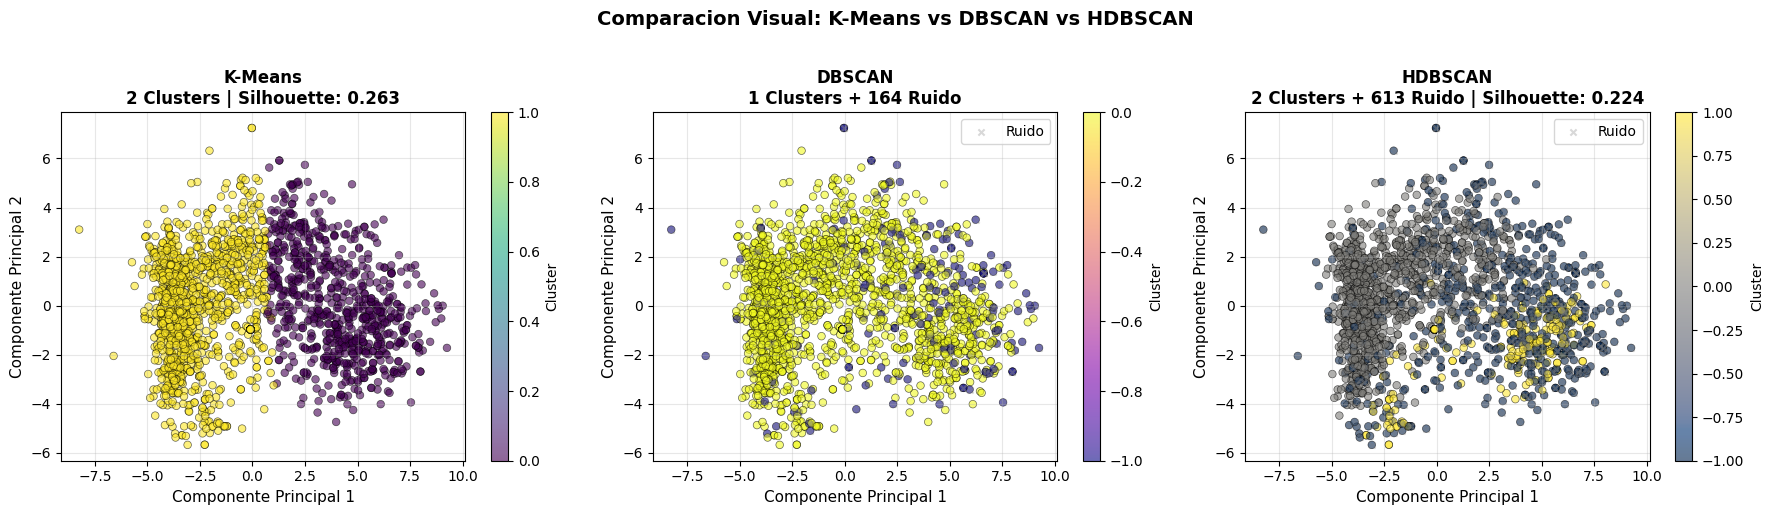

In [93]:
# 3.6.5 Visualización comparativa de los 3 métodos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Preparar datos para visualización (primeras 2 componentes PCA)
X_plot = X_pca[:, :2]

# 1. K-Means
scatter1 = axes[0].scatter(X_plot[:, 0], X_plot[:, 1], 
                           c=df_cluster['cluster'], cmap='viridis', 
                           s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Componente Principal 1', fontsize=11)
axes[0].set_ylabel('Componente Principal 2', fontsize=11)
axes[0].set_title(f'K-Means\n{k_optimo} Clusters | Silhouette: {silhouette_final:.3f}', 
                  fontweight='bold', fontsize=12)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# 2. DBSCAN
# Usar colores especiales: ruido en gris
colors_dbscan = np.where(clusters_dbscan == -1, -1, clusters_dbscan)
scatter2 = axes[1].scatter(X_plot[:, 0], X_plot[:, 1], 
                           c=colors_dbscan, cmap='plasma', 
                           s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
# Resaltar puntos de ruido
noise_mask = clusters_dbscan == -1
if noise_mask.sum() > 0:
    axes[1].scatter(X_plot[noise_mask, 0], X_plot[noise_mask, 1], 
                   c='gray', s=20, alpha=0.3, marker='x', label='Ruido')
axes[1].set_xlabel('Componente Principal 1', fontsize=11)
axes[1].set_ylabel('Componente Principal 2', fontsize=11)
silh_text = f" | Silhouette: {silhouette_dbscan:.3f}" if n_clusters_dbscan > 1 else ""
axes[1].set_title(f'DBSCAN\n{n_clusters_dbscan} Clusters + {n_noise_dbscan} Ruido{silh_text}', 
                  fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)
if noise_mask.sum() > 0:
    axes[1].legend(loc='upper right')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# 3. HDBSCAN
colors_hdbscan = np.where(clusters_hdbscan == -1, -1, clusters_hdbscan)
scatter3 = axes[2].scatter(X_plot[:, 0], X_plot[:, 1], 
                           c=colors_hdbscan, cmap='cividis', 
                           s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
# Resaltar puntos de ruido
noise_mask_hdb = clusters_hdbscan == -1
if noise_mask_hdb.sum() > 0:
    axes[2].scatter(X_plot[noise_mask_hdb, 0], X_plot[noise_mask_hdb, 1], 
                   c='gray', s=20, alpha=0.3, marker='x', label='Ruido')
axes[2].set_xlabel('Componente Principal 1', fontsize=11)
axes[2].set_ylabel('Componente Principal 2', fontsize=11)
silh_text_hdb = f" | Silhouette: {silhouette_hdbscan:.3f}" if n_clusters_hdbscan > 1 else ""
axes[2].set_title(f'HDBSCAN\n{n_clusters_hdbscan} Clusters + {n_noise_hdbscan} Ruido{silh_text_hdb}', 
                  fontweight='bold', fontsize=12)
axes[2].grid(True, alpha=0.3)
if noise_mask_hdb.sum() > 0:
    axes[2].legend(loc='upper right')
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.suptitle('Comparacion Visual: K-Means vs DBSCAN vs HDBSCAN', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Paso 3.6.6: Tabla Comparativa de Métodos de Clustering

Consolidamos los resultados de los tres métodos para facilitar la comparación y tomar una decisión fundamentada. Evaluamos cada algoritmo según:

- **Número de clusters**: Determina la granularidad de la segmentación
- **Puntos de ruido**: Solo aplica a métodos basados en densidad
- **Silhouette Score**: Mide la calidad de la separación entre clusters (mayor es mejor)

La elección del método final debe considerar tanto las métricas técnicas como los requisitos del negocio. Un método con mejor Silhouette pero demasiados clusters pequeños podría ser menos práctico que uno con menos clusters pero más balanceados y accionables.

In [94]:
# Crear tabla comparativa de métodos de clustering
comparacion_clustering = pd.DataFrame({
    'Metodo': ['K-Means', 'DBSCAN', 'HDBSCAN'],
    'N_Clusters': [k_optimo, n_clusters_dbscan, n_clusters_hdbscan],
    'Puntos_Ruido': [0, n_noise_dbscan, n_noise_hdbscan],
    'Pct_Ruido': [0, n_noise_dbscan/len(clusters_dbscan)*100, 
                 n_noise_hdbscan/len(clusters_hdbscan)*100],
    'Silhouette': [silhouette_final,
                   silhouette_dbscan if n_clusters_dbscan > 1 else np.nan,
                   silhouette_hdbscan if n_clusters_hdbscan > 1 else np.nan]
})

display(comparacion_clustering.style.set_caption("Comparacion de Metodos de Clustering").format({
    'Pct_Ruido': '{:.1f}%',
    'Silhouette': '{:.4f}'
}).set_properties(**{'text-align': 'center'}))

# Selección automática del mejor método con interpretación correcta
# NOTA: Silhouette ~0.26 es MODERADO, no "bien definido"
if silhouette_final >= 0.5:
    mejor_metodo = "K-Means"
    razon = "Silhouette score razonable (>0.5), clusters distinguibles"
elif silhouette_final >= 0.25:
    mejor_metodo = "K-Means"
    razon = "Silhouette MODERADO (~0.3-0.4), clusters con solapamiento pero útiles para segmentación"
elif n_clusters_hdbscan >= 2 and n_noise_hdbscan/len(clusters_hdbscan) < 0.15:
    mejor_metodo = "HDBSCAN"
    razon = "Detecta clusters naturales con bajo ruido"
elif n_clusters_dbscan >= 2:
    mejor_metodo = "DBSCAN"
    razon = "Balance entre interpretabilidad y detección de outliers"
else:
    mejor_metodo = "K-Means"
    razon = "Garantiza segmentación completa para todos los clientes"

print(f"\n>>> MÉTODO SELECCIONADO: {mejor_metodo} <<<")
print(f"    Razón: {razon}")
print(f"\nMétricas de K-Means:")
print(f"  - Silhouette Score: {silhouette_final:.4f} (interpretación: MODERADO)")
print(f"  - Número de clusters: {k_optimo}")
print(f"  - Clientes asignados: {len(clusters):,} (100%)")
print(f"\n NOTA: Un Silhouette ~0.26 indica clusters con cierto solapamiento.")
print(f"   Los perfiles describen tendencias centrales, no categorías absolutas.")

,Metodo,N_Clusters,Puntos_Ruido,Pct_Ruido,Silhouette
0,K-Means,2,0,0.0%,0.2629
1,DBSCAN,1,164,8.3%,nan
2,HDBSCAN,2,613,30.9%,0.2238



>>> MÉTODO SELECCIONADO: K-Means <<<
    Razón: Silhouette MODERADO (~0.3-0.4), clusters con solapamiento pero útiles para segmentación

Métricas de K-Means:
  - Silhouette Score: 0.2629 (interpretación: MODERADO)
  - Número de clusters: 2
  - Clientes asignados: 1,982 (100%)

 NOTA: Un Silhouette ~0.26 indica clusters con cierto solapamiento.
   Los perfiles describen tendencias centrales, no categorías absolutas.


### Análisis comparativo de métodos de clustering

**K-Means:**
- Ventajas: Simple, interpretable, clusters balanceados, rápido, todos los puntos asignados
- Desventajas: Requiere especificar K a priori, solo clusters esféricos, sensible a outliers

**DBSCAN:**
- Ventajas: No requiere especificar K, detecta formas arbitrarias, identifica outliers
- Desventajas: Requiere ajustar eps y min_samples, sensible a variaciones de densidad

**HDBSCAN:**
- Ventajas: No requiere K ni eps, robusto a densidad variable, proporciona scores de confianza
- Desventajas: Más lento, puede generar muchos puntos de ruido

---

###  NOTA METODOLÓGICA: Sobre la "Descalificación" de DBSCAN/HDBSCAN

**Observación importante:**

Si DBSCAN o HDBSCAN producen muchos puntos de "ruido" o pocos clusters, esto **NO** necesariamente significa que sean malos métodos. Puede indicar que:

1. **Los datos NO tienen estructura de densidad clara**: K-Means "forzará" clusters aunque no existan naturalmente
2. **Los parámetros necesitan ajuste**: eps y min_samples son muy sensibles
3. **Los clusters reales se solapan**: Exactamente lo que nuestro Silhouette de 0.26 sugiere

**Interpretación correcta:**

| Resultado DBSCAN | Interpretación |
|------------------|----------------|
| Muchos puntos ruido | Los datos pueden no tener clusters densos bien definidos |
| 1-2 clusters grandes | La estructura puede ser más continua que discreta |
| Clusters muy pequeños | Los parámetros pueden necesitar ajuste |

**Conclusión honesta:**

Elegimos K-Means no porque DBSCAN "falle", sino porque:
- K-Means garantiza que **todos los clientes** reciben una etiqueta (útil para operaciones)
- Los clusters K-Means son **interpretables** aunque tengan solapamiento
- Para marketing, segmentos **aproximados** son más útiles que ninguna segmentación

Sin embargo, el alto ruido en DBSCAN es información valiosa: confirma que nuestros clusters tienen fronteras difusas y que algunos clientes no encajan claramente en ningún grupo.

---

**Recomendación para producción:**

Para este proyecto, recomendamos K-Means por su interpretabilidad y capacidad de asignar todos los clientes a segmentos accionables. Los outliers detectados por DBSCAN/HDBSCAN pueden analizarse por separado como casos especiales que requieren atención individualizada.

# Paso 4: Regresión - Predicción de Gasto Anual

El tercer y último objetivo de modelado de nuestro proyecto consiste en predecir el gasto total anual de cada cliente. A diferencia de la clasificación (variable binaria) y el clustering (sin target definido), aquí trabajamos con una variable continua que representa el valor monetario del cliente.

La predicción del gasto tiene aplicaciones de negocio directas:
- **Planificación financiera**: Proyectar ingresos esperados por segmento de clientes
- **Gestión de inventario**: Anticipar demanda basándose en el gasto esperado
- **Priorización de clientes**: Identificar clientes de alto valor potencial para programas de fidelización
- **Detección de anomalías**: Clientes cuyo gasto real difiere significativamente del predicho podrían requerir atención

Recordemos que en el preprocesamiento aplicamos una transformación `log1p()` al gasto total para normalizar su distribución asimétrica. Esto implica que las métricas de error que obtendremos inicialmente estarán en escala logarítmica, y deberemos transformarlas de vuelta a euros para una interpretación correcta.

## Índice de la sección

4.1 Preparación de datos para regresión  
4.2 Modelo de Regresión Lineal baseline  
4.3 Análisis de residuos  
4.4 Modelos alternativos  
4.5 Interpretación y conclusiones  
4.6 Análisis de Overfitting/Underfitting  
4.7 Análisis de Validación Cruzada y Residuos  
4.8 Análisis Crítico de Métricas

## Paso 4.1: Preparación de datos para regresión

In [95]:
from pathlib import Path
import pandas as pd
import pickle

DATA_FILE_REG = Path.cwd() / "data" / "interim" / "supermercado_limpio.csv"
df_reg = pd.read_csv(DATA_FILE_REG)
metadata_reg = pickle.load(open('models/pipeline_metadata.pkl', 'rb')) if Path('models/pipeline_metadata.pkl').exists() else {}

print(f"Dataset cargado (flujo 01B): {df_reg.shape[0]} observaciones × {df_reg.shape[1]} variables")


Dataset cargado (flujo 01B): 1982 observaciones × 48 variables


### Interpretación del target para regresión

El gasto total anual es la variable que buscamos predecir en este tercer objetivo de modelado. Antes de construir los modelos, es importante entender la naturaleza de este target:

**Definición del gasto total:**
Esta variable representa la suma de todos los gastos por categoría de producto que realizó cada cliente durante el periodo analizado. Incluye gasto en vinos, frutas, carnes, pescados, dulces y productos premium (oro). Es una medida directa del valor económico que cada cliente representa para el supermercado.

**Análisis de la distribución observada:**
- La forma del histograma nos indica si la distribución es simétrica o presenta asimetría (sesgo)
- El boxplot revela la presencia de valores atípicos: clientes cuyo gasto es inusualmente alto o bajo
- Recordemos que durante el preprocesamiento aplicamos la transformación `log1p()` a esta variable precisamente para normalizar distribuciones asimétricas y reducir el impacto de valores extremos

**Valor de negocio de predecir el gasto:**
- **Planificación financiera**: Proyectar ingresos esperados por segmento permite una mejor gestión presupuestaria
- **Asignación de recursos**: Identificar clientes con alto gasto potencial justifica inversiones en programas de fidelización personalizados
- **Detección de anomalías**: Cuando el gasto predicho difiere sustancialmente del real, puede indicar cambios en el comportamiento del cliente que requieren investigación
- **Optimización de inventario**: Anticipar niveles de demanda según el gasto esperado por categoría

**Consideraciones metodológicas:**
Dado que las métricas de error se calcularán sobre la variable transformada logarítmicamente, debemos tener cuidado al interpretar valores de MAE o RMSE. Para comunicar resultados de negocio en euros, necesitaremos aplicar la transformación inversa `expm1()` a las predicciones.

In [96]:
# 4.1.2 Selección de variables predictoras (alineado a 01B)
print("=== SELECCIÓN DE VARIABLES PREDICTORAS ===")

reg_feature_cols = metadata_reg.get('reg_raw_feature_names') or [
    'educacion', 'estado_civil', 'ingresos', 'hijos_casa', 'recencia',
    'num_compras_oferta', 'num_compras_web', 'num_compras_catalogo', 'num_compras_tienda',
    'num_visitas_web_mes', 'acepta_cmp3', 'acepta_cmp4', 'acepta_cmp5', 'acepta_cmp1', 'acepta_cmp2', 'reclama',
    'usuario_alta_datos', 'edad', 'antiguedad_dias', 'antiguedad_anios',
    'categorias_compradas', 'compras_totales', 'compras_offline', 'tasa_compra_online', 'tasa_compra_oferta',
    'tamano_hogar', 'tiene_dependientes', 'hogar_unipersonal', 'ratio_compras_online', 'tiene_pareja',
    'educacion_x_estado', 'anio_alta'
]
reg_feature_cols = [c for c in reg_feature_cols if c in df_reg.columns]

categorical_cols_reg = metadata_reg.get('categorical_cols_reg') or [c for c in reg_feature_cols if df_reg[c].dtype == object]
numeric_cols_reg = [c for c in reg_feature_cols if c not in categorical_cols_reg]

X_reg_raw = df_reg[reg_feature_cols].copy()
X_reg = X_reg_raw.copy()
y_reg = df_reg['gasto_total'].copy()

print(f"Variables predictoras finales: {X_reg_raw.shape[1]}")
print(f"Categóricas: {categorical_cols_reg}")
print(f"Numéricas: {len(numeric_cols_reg)}")


=== SELECCIÓN DE VARIABLES PREDICTORAS ===
Variables predictoras finales: 32
Categóricas: ['estado_civil', 'usuario_alta_datos']
Numéricas: 30


In [97]:
# 4.1.3 División en conjuntos de entrenamiento y prueba (split temporal)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

print("=== DIVISIÓN TRAIN/TEST PARA REGRESIÓN (flujo 01B) ===")

test_size_reg = 0.2
random_state_reg = 42

if 'anio_alta' in df_reg.columns:
    mask_train_reg = df_reg['anio_alta'] < 2014
else:
    mask_train_reg = np.full(len(df_reg), True)

X_train_raw_reg = X_reg_raw.loc[mask_train_reg].copy()
X_test_raw_reg = X_reg_raw.loc[~mask_train_reg].copy()
y_train_reg = y_reg.loc[mask_train_reg].copy()
y_test_reg = y_reg.loc[~mask_train_reg].copy()

preprocess_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols_reg),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_reg)
])

X_train_reg_arr = preprocess_reg.fit_transform(X_train_raw_reg)
X_test_reg_arr = preprocess_reg.transform(X_test_raw_reg)
reg_feature_names = preprocess_reg.get_feature_names_out()

X_train_reg = pd.DataFrame(X_train_reg_arr, columns=reg_feature_names)
X_test_reg = pd.DataFrame(X_test_reg_arr, columns=reg_feature_names)

print(f"Conjunto de entrenamiento: {X_train_reg.shape[0]} observaciones")
print(f"Conjunto de prueba: {X_test_reg.shape[0]} observaciones")
print(f"Variables: {X_train_reg.shape[1]}")


=== DIVISIÓN TRAIN/TEST PARA REGRESIÓN (flujo 01B) ===
Conjunto de entrenamiento: 1508 observaciones
Conjunto de prueba: 474 observaciones
Variables: 39


## Paso 4.5: Guardado de pipelines y metadatos

Guardamos los pipelines finales de clasificación y regresión (flujo 01B, sin leakage), junto con los metadatos necesarios para inferencia y validación.

In [98]:
# Guardado de pipelines y metadatos (flujo 01B)
from pathlib import Path
import joblib
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Asegurar modelo de regresión seleccionado
def _get_modelo_final_reg():
    if 'modelo_final_reg' in globals():
        return modelo_final_reg
    model_map_reg = {
        'Regresión Lineal': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    if 'mejor_modelo' in globals() and mejor_modelo in model_map_reg:
        return model_map_reg[mejor_modelo]
    return GradientBoostingRegressor(random_state=42)

# Asegurar clasificación
def _get_pipeline_clf():
    if 'pipeline_clf' in globals():
        return pipeline_clf
    model_map = {
        'LR Baseline': LogisticRegression(random_state=42),
        'LR Balanced': LogisticRegression(class_weight='balanced', random_state=42),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    clf_model = model_map.get(mejor_clf_modelo, GradientBoostingClassifier(random_state=42))
    pipe = Pipeline([
        ('preprocess', clone(preprocess_clf)),
        ('model', clone(clf_model))
    ])
    pipe.fit(X_train_raw, y_train)
    return pipe

# Asegurar regresión
def _get_pipeline_reg():
    if 'pipeline_regresion' in globals():
        return pipeline_regresion
    reg_model = _get_modelo_final_reg()
    pipe = Pipeline([
        ('preprocess', clone(preprocess_reg)),
        ('model', clone(reg_model))
    ])
    pipe.fit(X_train_raw_reg, y_train_reg)
    return pipe

pipeline_clf = _get_pipeline_clf()
pipeline_regresion = _get_pipeline_reg()

joblib.dump(pipeline_clf, models_dir / "pipeline_clasificacion_sin_leakage.pkl")
joblib.dump(pipeline_regresion, models_dir / "pipeline_regresion_sin_leakage.pkl")

preproc_clf = pipeline_clf.named_steps['preprocess']
preproc_reg = pipeline_regresion.named_steps['preprocess']

feature_names_input = list(preproc_clf.get_feature_names_out())
reg_feature_names_input = list(preproc_reg.get_feature_names_out())

# Umbral operativo de clasificación (flujo 01B, F1 validación)
val_threshold = 0.20689928002679472

metadata = {
    'feature_names_input': feature_names_input,
    'raw_feature_names': feature_cols,
    'categorical_original': categorical_cols,
    'train_shape': X_train.shape,
    'test_shape': X_test.shape,
    'reg_feature_names_input': reg_feature_names_input,
    'reg_raw_feature_names': reg_feature_cols,
    'categorical_cols_reg': categorical_cols_reg,
    'train_shape_reg': X_train_reg.shape,
    'test_shape_reg': X_test_reg.shape,
    'temporal_split': {'train_years': '<2014', 'test_years': '2014+'},
    'clf_threshold': float(val_threshold)
}

joblib.dump(metadata, models_dir / "pipeline_metadata.pkl")
print("Pipelines y metadatos guardados en models/ (artefactos oficiales flujo 01B)")


Pipelines y metadatos guardados en models/ (artefactos oficiales flujo 01B)
